In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import popoff
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder
import loadpaths
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import sys

/Users/danieldaylewis/Documents/code/popping-off/popoff/popoff/loadpaths.py


In [3]:
user_paths = loadpaths.loadpaths()
sys.path.append(user_paths['base_path'])
from pySpatialNeuronNet import factor_analysis

In [12]:
plt.style.use("dark_background")

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

COLORS = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
]

## Load Both PoolAcrossSessions class and example LinearModel class
* PoolAcrossSessions loads 4 example sessions and has an attribute 'linear_models', a list of len n_sessions containing a LinearModel object for every session
* The PoolAcrossSessions class has methods that match the methods in LinearModel, producing the same plots across sessions
* PAS also computes PC array for each session and saves it into the object. This can be recomputed by setting save_PCA=True.


In [5]:
remove_targets = True
pas = PoolAcrossSessions(save_PCA=False, remove_targets=remove_targets)
session = pas.sessions[2]  # Example session for some plots
lm = LinearModel(session, pas.times_use, remove_targets=remove_targets)  # Example LinearModel object for some plots

## Model is able to switch between binary classification and multiclass.
### Below is just results of the multiclass model
### First plot the full model performance as a function of regularisation strength

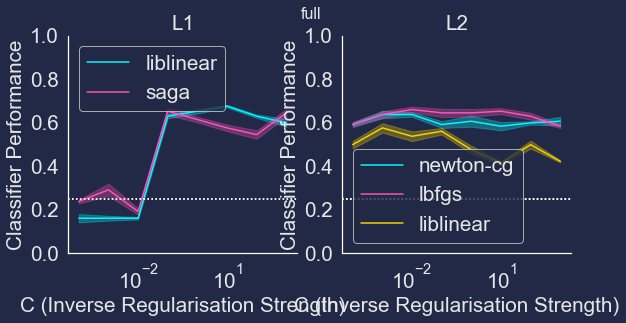

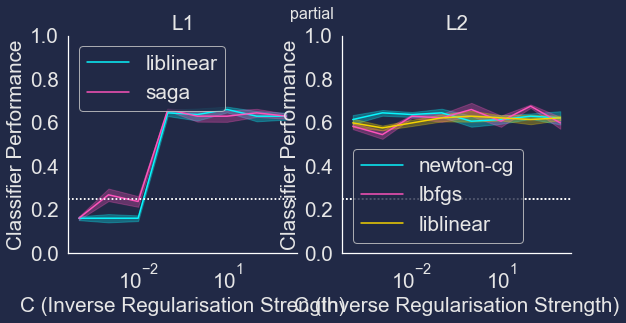

In [6]:
lm.model_params_plot(outcomes=['hit', 'miss', 'fp', 'cr'])

## Performance of partial model as a function of sequentially added covariates

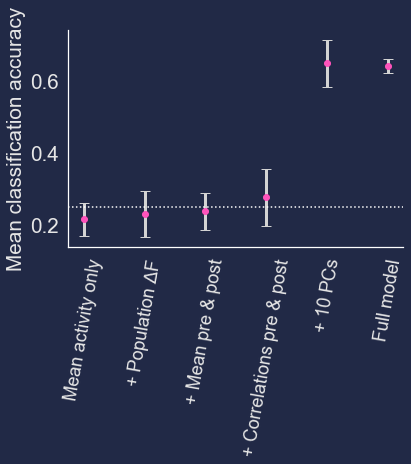

In [9]:
# For a single session
_ = lm.partial_model_performance('all', multiclass=True)

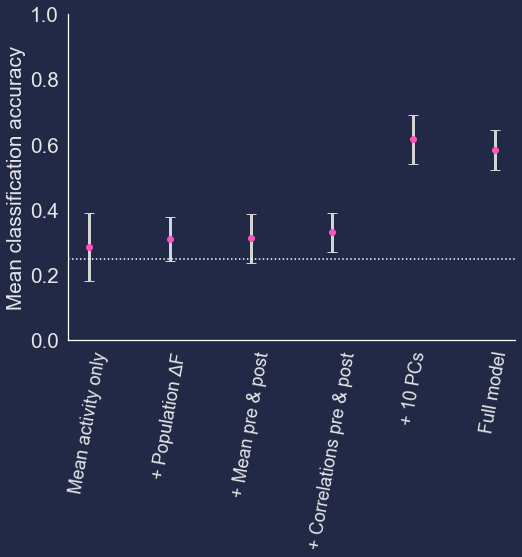

In [14]:
pas.partial_model_performance('all', multiclass=True)

## Examine betas of the partial model for different trial types

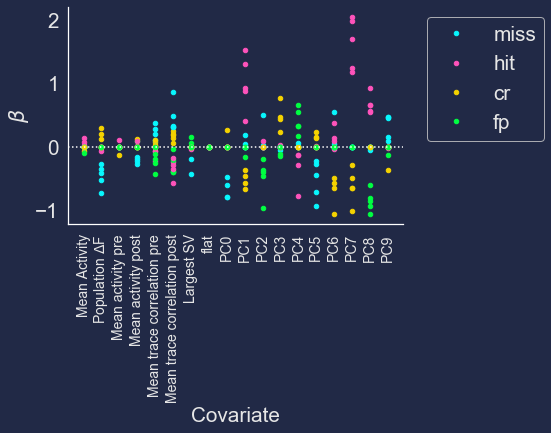

In [49]:
# For a single session
_ = lm.plot_betas(frames='all', model='partial', multiclass=True)

In [51]:
# Across sessions
pas.plot_betas(frames='all', model='partial', multiclass=True, n_comps_in_partial=10)

KeyboardInterrupt: 

In [53]:
session = lm.session
session.load_data()

Now loading mouse J048, run 27
/home/jrowland/Documents/code/Vape/run_pkls/J048/run27.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/home/jrowland/Documents/code/Vape/run_pkls/J048/run27.pkl'

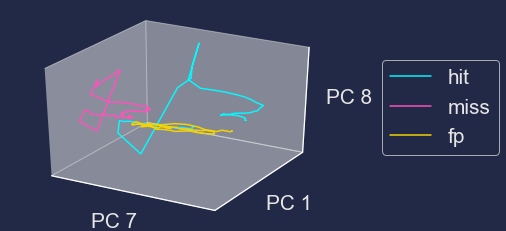

In [13]:
# Get your manifold out
outcomes = session.outcome[session.nonnan_trials]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx, outcome in enumerate(['hit', 'miss', 'fp']):
    PCs = lm.session.comps[:, outcomes==outcome, :]
    PCs = np.mean(PCs, 1)
    ax.plot(xs=PCs[1,:], ys=PCs[7,:], zs=PCs[8,:], label=outcome, color=COLORS[idx])
    
ax.set_xlabel('PC 7')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 8')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.legend(bbox_to_anchor=(1.5,0.8))

## Can you decode just from s2 and/or just from pre-frames?

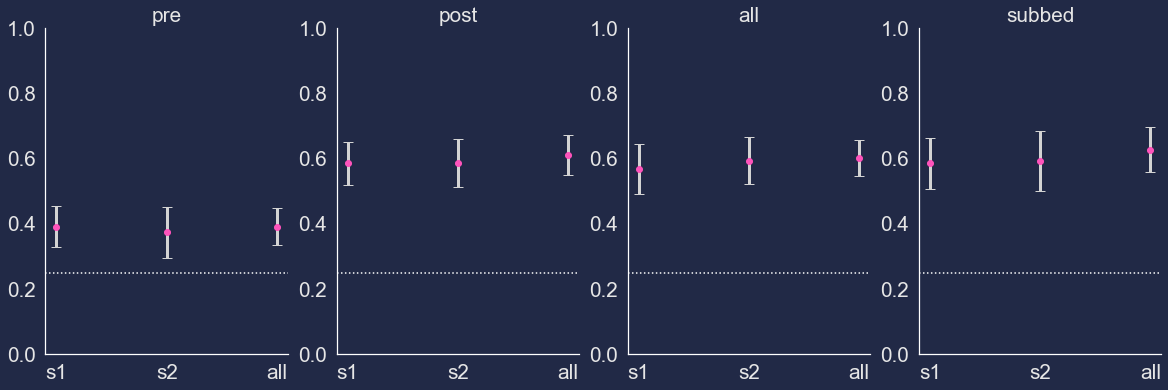

In [14]:
plt.figure(figsize=(20,6))

n_plots = 0
for frames in ['pre', 'post', 'all', 'subbed']:
    n_plots += 1
    plt.subplot(1,4,n_plots)
    pas.compare_regions(frames=frames)
    plt.title(frames)

## Uneven trial numbers can lead to bias, so check bias is not too strong

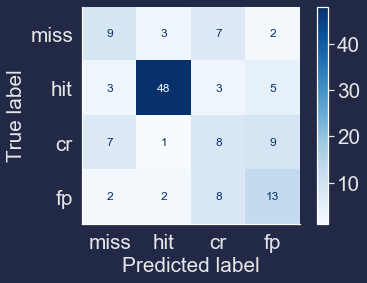

In [15]:
lm = LinearModel(session, pas.times_use)
X, y = lm.prepare_data(model='full', outcomes=['hit', 'miss', 'fp', 'cr'])
acc, std_acc, models = lm.logistic_regression(X, y, 'l1', 0.5, 'saga', compute_confusion=True)

C = np.sum(lm.confusion_matrix, 2)
cmd = ConfusionMatrixDisplay(C, display_labels=lm.encoder.inverse_transform([0,1,2,3]))
cmd.plot(cmap ='Blues')

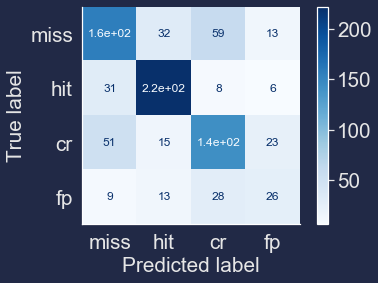

In [16]:
pas.build_confusion_matrix()

## Does the target info of the cell impact the model coefs?

NULL REJECTED!!
14.04% of cells have non-0 coefs


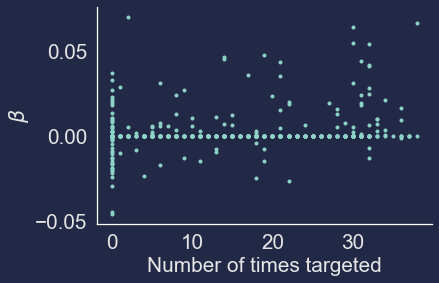

In [17]:
# Re-init the linear_model class with targets
lm = LinearModel(session, pas.times_use, remove_targets=False)
lm.beta_targets_correlation('s1')

NULL REJECTED!!
10.83% of cells have non-0 coefs


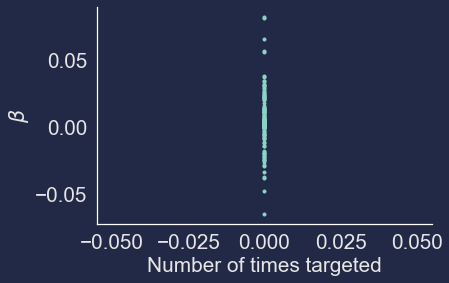

In [18]:
lm.beta_targets_correlation('s2')

(0, 10)

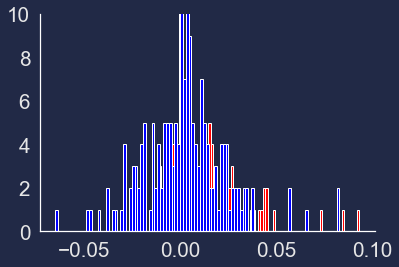

In [19]:
# Distribution of coefs for targets and non targets
plt.hist(lm.hit_coef[lm.ever_targetted], 100, color='red')
plt.hist(lm.hit_coef[~lm.ever_targetted], 100, color='blue')
plt.ylim(0,10)

## This plot motivates the use of multiclass over binary classifier. If you project the hit/miss classifier onto fp vs cr data you can still decode above chance

Text(0, 0.5, 'Classification Accuracy')

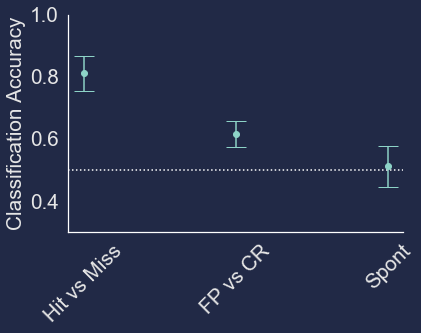

In [20]:
means, stds = pas.project_model('all', 'full')
plt.errorbar([0,1,2], means, stds, marker='o', capsize=10, linestyle='')
plt.ylim(0.3, 1)
plt.xticks([0,1,2], ['Hit vs Miss', 'FP vs CR', 'Spont'], rotation=45)
plt.axhline(0.5, linestyle=':')
plt.ylabel('Classification Accuracy')

### Try out the GPFA port

In [ ]:
# A single hit trial
# needs to be x_dim x N
arr = lm.session.behaviour_trials

# The 10th hit trial
trial_idx = np.where(session.outcome[session.nonnan_trials]=='hit')[0][10]
trial = arr[:, trial_idx, :]

dims = factor_analysis.crossvalidate_fa(trial, verbose=True)


Processing latent dimensionality 1
Cross validation fold 1
EM iteration 4 lik -21645.040954713746 base = 423.1748406400807
EM iteration 5 lik -20839.57783316008 base = 976.723323650231
EM iteration 6 lik -20067.560479411062 base = 1782.1864532585269
EM iteration 7 lik -19588.68836954738 base = 2554.2038147277194
EM iteration 8 lik -19344.653482813635 base = 3033.075929380122
EM iteration 9 lik -19212.79918471411 base = 3277.110818554216
EM iteration 10 lik -19129.948028088693 base = 3408.9651179722855
EM iteration 11 lik -19070.82382178596 base = 3491.8162754262135
EM iteration 12 lik -19024.879934094002 base = 3550.9404823201867
EM iteration 13 lik -18987.095286461816 base = 3596.884370471585
EM iteration 14 lik -18954.751136839506 base = 3634.669018481618
EM iteration 15 lik -18926.236501963765 base = 3667.013168427369
EM iteration 16 lik -18900.55952991308 base = 3695.527803588256
EM iteration 17 lik -18877.08479744901 base = 3721.204775895711
EM iteration 18 lik -18855.41492605523 

EM iteration 130 lik -18682.13251394275 base = 3939.563471951542
EM iteration 131 lik -18682.064234888865 base = 3939.6317940503113
EM iteration 132 lik -18681.996521900823 base = 3939.700073104879
EM iteration 133 lik -18681.92848076961 base = 3939.7677860935983
EM iteration 134 lik -18681.860703990693 base = 3939.8358272254923
EM iteration 135 lik -18681.793097729016 base = 3939.9036040050864
EM iteration 136 lik -18681.72514436303 base = 3939.9712102674393
EM iteration 137 lik -18681.657920809215 base = 3940.0391636341046
EM iteration 138 lik -18681.591019111373 base = 3940.1063871885917
EM iteration 139 lik -18681.523638905084 base = 3940.173288887104
EM iteration 140 lik -18681.456114523105 base = 3940.2406690940657
EM iteration 141 lik -18681.38830565475 base = 3940.3081934767197
EM iteration 142 lik -18681.319873393928 base = 3940.376002345754
EM iteration 143 lik -18681.25184666041 base = 3940.4444346072596
EM iteration 144 lik -18681.184509160994 base = 3940.512461341459
EM it

EM iteration 254 lik -18673.722051547506 base = 3947.9742434286336
EM iteration 255 lik -18673.654039718247 base = 3948.0422565296603
EM iteration 256 lik -18673.586658696033 base = 3948.110268359599
EM iteration 257 lik -18673.518247245207 base = 3948.177649382487
EM iteration 258 lik -18673.450733296908 base = 3948.246060833997
EM iteration 259 lik -18673.383169160996 base = 3948.313574782971
EM iteration 260 lik -18673.315463203224 base = 3948.381138919559
EM iteration 261 lik -18673.247890383565 base = 3948.448844878008
EM iteration 262 lik -18673.179870675187 base = 3948.516417698342
EM iteration 263 lik -18673.11219669519 base = 3948.584437407401
EM iteration 264 lik -18673.0441142103 base = 3948.652111388074
EM iteration 265 lik -18672.97635914613 base = 3948.7201938736443
EM iteration 266 lik -18672.9084982892 base = 3948.7879489384923
EM iteration 267 lik -18672.84054375597 base = 3948.8558097960995
EM iteration 268 lik -18672.773045949347 base = 3948.9237643300107
EM iteratio

EM iteration 378 lik -18665.306886908096 base = 3956.3896573486813
EM iteration 379 lik -18665.238827345085 base = 3956.457421253221
EM iteration 380 lik -18665.170981011062 base = 3956.525480816913
EM iteration 381 lik -18665.10329705888 base = 3956.593327151614
EM iteration 382 lik -18665.035590857544 base = 3956.6610111044747
EM iteration 383 lik -18664.967851638263 base = 3956.7287173064865
EM iteration 384 lik -18664.900018859757 base = 3956.796456526445
EM iteration 385 lik -18664.83209174801 base = 3956.86428930563
EM iteration 386 lik -18664.76391678598 base = 3956.9322164180567
EM iteration 387 lik -18664.69605935888 base = 3957.0003913807654
EM iteration 388 lik -18664.628172694764 base = 3957.068248808545
EM iteration 389 lik -18664.560188841933 base = 3957.136135473341
EM iteration 390 lik -18664.492416816305 base = 3957.204119326851
EM iteration 391 lik -18664.424409299565 base = 3957.271891353157
EM iteration 392 lik -18664.35650922705 base = 3957.339898870577
EM iteratio

EM iteration 504 lik -18656.751520093952 base = 3964.9448934388033
EM iteration 505 lik -18656.683578821205 base = 3965.012788152919
EM iteration 506 lik -18656.61566791207 base = 3965.080729426346
EM iteration 507 lik -18656.54778525827 base = 3965.148640336161
EM iteration 508 lik -18656.479897162455 base = 3965.2165229906386
EM iteration 509 lik -18656.411959989848 base = 3965.2844110871324
EM iteration 510 lik -18656.344046240578 base = 3965.352348260419
EM iteration 511 lik -18656.276062755525 base = 3965.420262010368
EM iteration 512 lik -18656.20808678671 base = 3965.4882454961003
EM iteration 513 lik -18656.140166777244 base = 3965.556221465594
EM iteration 514 lik -18656.072245067415 base = 3965.6241414757405
EM iteration 515 lik -18656.004433909227 base = 3965.692063186249
EM iteration 516 lik -18655.936526355414 base = 3965.7598743451144
EM iteration 517 lik -18655.868711327857 base = 3965.8277818996075
EM iteration 518 lik -18655.800845958118 base = 3965.895596927842
EM ite

EM iteration 630 lik -18648.197640258273 base = 3973.4988108556363
EM iteration 631 lik -18648.129774862064 base = 3973.566668074137
EM iteration 632 lik -18648.061907493437 base = 3973.634533471025
EM iteration 633 lik -18647.99402801277 base = 3973.7024008403305
EM iteration 634 lik -18647.926143146455 base = 3973.7702803216757
EM iteration 635 lik -18647.858236162203 base = 3973.8381651886702
EM iteration 636 lik -18647.79030721057 base = 3973.906072173601
EM iteration 637 lik -18647.722390666044 base = 3973.974001125914
EM iteration 638 lik -18647.654519360403 base = 3974.041917671119
EM iteration 639 lik -18647.58662701353 base = 3974.109788977438
EM iteration 640 lik -18647.518736442224 base = 3974.17768132499
EM iteration 641 lik -18647.45090660046 base = 3974.2455718969754
EM iteration 642 lik -18647.383003187322 base = 3974.3134017394163
EM iteration 643 lik -18647.315152085983 base = 3974.3813051532343
EM iteration 644 lik -18647.24732185359 base = 3974.449156255252
EM iterat

EM iteration 754 lik -18639.781019694114 base = 3981.9154229777837
EM iteration 755 lik -18639.71314161917 base = 3981.9832887224625
EM iteration 756 lik -18639.64529015561 base = 3982.0511667980854
EM iteration 757 lik -18639.57743039827 base = 3982.1190182623222
EM iteration 758 lik -18639.509573855394 base = 3982.186878020343
EM iteration 759 lik -18639.441690896878 base = 3982.254734563897
EM iteration 760 lik -18639.373815561965 base = 3982.3226175230916
EM iteration 761 lik -18639.30594958026 base = 3982.3904928586835
EM iteration 762 lik -18639.238082485783 base = 3982.458358841068
EM iteration 763 lik -18639.17021317628 base = 3982.5262259362225
EM iteration 764 lik -18639.102353135677 base = 3982.594095246405
EM iteration 765 lik -18639.034483694588 base = 3982.661955287686
EM iteration 766 lik -18638.96661831659 base = 3982.729824729454
EM iteration 767 lik -18638.898766424347 base = 3982.79769010813
EM iteration 768 lik -18638.830904711 base = 3982.865542001052
EM iteration 

EM iteration 880 lik -18631.2321939499 base = 3990.464273853171
EM iteration 881 lik -18631.164355728208 base = 3990.532114552163
EM iteration 882 lik -18631.096529464005 base = 3990.5999527745353
EM iteration 883 lik -18631.028697160516 base = 3990.6677790394165
EM iteration 884 lik -18630.960871043157 base = 3990.735611343583
EM iteration 885 lik -18630.893036666297 base = 3990.803437461621
EM iteration 886 lik -18630.82520451791 base = 3990.871271839159
EM iteration 887 lik -18630.757380136463 base = 3990.939103988224
EM iteration 888 lik -18630.689558030994 base = 3991.006928370349
EM iteration 889 lik -18630.621723609198 base = 3991.074750476497
EM iteration 890 lik -18630.553890405172 base = 3991.142584898971
EM iteration 891 lik -18630.486070104373 base = 3991.2104181036757
EM iteration 892 lik -18630.418239704173 base = 3991.278238405153
EM iteration 893 lik -18630.35040302042 base = 3991.346068806031
EM iteration 894 lik -18630.282576962687 base = 3991.413905490462
EM iteratio

EM iteration 1006 lik -18622.688059891458 base = 3999.0084609131177
EM iteration 1007 lik -18622.620275134832 base = 3999.076248696048
EM iteration 1008 lik -18622.552491212176 base = 3999.1440334533518
EM iteration 1009 lik -18622.484704679555 base = 3999.211817376685
EM iteration 1010 lik -18622.41692595809 base = 3999.2796039099844
EM iteration 1011 lik -18622.349143422936 base = 3999.3473826321288
EM iteration 1012 lik -18622.281360011315 base = 3999.4151651679585
EM iteration 1013 lik -18622.21357772935 base = 3999.482948580258
EM iteration 1014 lik -18622.145790783186 base = 3999.550730862899
EM iteration 1015 lik -18622.078006770498 base = 3999.618517809742
EM iteration 1016 lik -18622.010226157552 base = 3999.6863018231084
EM iteration 1017 lik -18621.942439768747 base = 3999.754082436732
EM iteration 1018 lik -18621.87466163785 base = 3999.821868826215
EM iteration 1019 lik -18621.806878809548 base = 3999.8896469577912
EM iteration 1020 lik -18621.7391022847 base = 3999.957429

EM iteration 1128 lik -18614.421824424848 base = 4007.274761666285
EM iteration 1129 lik -18614.354100973607 base = 4007.3424842453205
EM iteration 1130 lik -18614.28637905894 base = 4007.410207697238
EM iteration 1131 lik -18614.218659797072 base = 4007.4779296125826
EM iteration 1132 lik -18614.15093758009 base = 4007.5456488751274
EM iteration 1133 lik -18614.083219511165 base = 4007.6133710927884
EM iteration 1134 lik -18614.015501948328 base = 4007.681089162389
EM iteration 1135 lik -18613.94778349434 base = 4007.7488067259033
EM iteration 1136 lik -18613.88006586006 base = 4007.8165251805694
EM iteration 1137 lik -18613.812350866923 base = 4007.8842428155262
EM iteration 1138 lik -18613.744634181443 base = 4007.9519578093395
EM iteration 1139 lik -18613.67691838048 base = 4008.019674495497
EM iteration 1140 lik -18613.609206662288 base = 4008.087390297138
EM iteration 1141 lik -18613.5414927523 base = 4008.1551020160064
EM iteration 1142 lik -18613.473778119638 base = 4008.222815

EM iteration 1252 lik -18606.029905062984 base = 4015.6667756965276
EM iteration 1253 lik -18605.96228014822 base = 4015.7344036911036
EM iteration 1254 lik -18605.894655538315 base = 4015.8020286065453
EM iteration 1255 lik -18605.82703198427 base = 4015.8696532171243
EM iteration 1256 lik -18605.759409068298 base = 4015.9372767718455
EM iteration 1257 lik -18605.691787430267 base = 4016.0048996884943
EM iteration 1258 lik -18605.624165739828 base = 4016.0725213272012
EM iteration 1259 lik -18605.55654548094 base = 4016.140143018317
EM iteration 1260 lik -18605.488924697704 base = 4016.2077632778805
EM iteration 1261 lik -18605.421305550546 base = 4016.2753840617934
EM iteration 1262 lik -18605.35368833536 base = 4016.343003209627
EM iteration 1263 lik -18605.286073458832 base = 4016.4106204254904
EM iteration 1264 lik -18605.21845827438 base = 4016.4782353026935
EM iteration 1265 lik -18605.150843761956 base = 4016.5458504878225
EM iteration 1266 lik -18605.08323004895 base = 4016.61

EM iteration 1375 lik -18597.71980220753 base = 4023.9770166759904
EM iteration 1376 lik -18597.652313263854 base = 4024.0445066296566
EM iteration 1377 lik -18597.584826368868 base = 4024.111995574009
EM iteration 1378 lik -18597.517340554332 base = 4024.1794824696703
EM iteration 1379 lik -18597.449856193765 base = 4024.246968284881
EM iteration 1380 lik -18597.38237284418 base = 4024.3144526461224
EM iteration 1381 lik -18597.314890645823 base = 4024.381935996384
EM iteration 1382 lik -18597.247410394113 base = 4024.4494181954146
EM iteration 1383 lik -18597.179931214683 base = 4024.516898447799
EM iteration 1384 lik -18597.112453441558 base = 4024.584377627904
EM iteration 1385 lik -18597.044977561884 base = 4024.6518554017043
EM iteration 1386 lik -18596.977502218724 base = 4024.719331282053
EM iteration 1387 lik -18596.91002903336 base = 4024.786806625887
EM iteration 1388 lik -18596.84255698294 base = 4024.854279811927
EM iteration 1389 lik -18596.77508578277 base = 4024.9217518

EM iteration 1499 lik -18589.362760003307 base = 4032.3342581490283
EM iteration 1500 lik -18589.295471465637 base = 4032.4015489174517
EM iteration 1501 lik -18589.22818469778 base = 4032.4688374557945
EM iteration 1502 lik -18589.160899920156 base = 4032.536124224326
EM iteration 1503 lik -18589.09361705993 base = 4032.603409002621
EM iteration 1504 lik -18589.026336378185 base = 4032.6706918635196
EM iteration 1505 lik -18588.959057566026 base = 4032.7379725459377
EM iteration 1506 lik -18588.8917809373 base = 4032.80525135877
EM iteration 1507 lik -18588.82450606765 base = 4032.872527988167
EM iteration 1508 lik -18588.75723312774 base = 4032.9398028584924
EM iteration 1509 lik -18588.689962179204 base = 4033.0070757990734
EM iteration 1510 lik -18588.6226935035 base = 4033.074346748283
EM iteration 1511 lik -18588.555426414794 base = 4033.1416154246585
EM iteration 1512 lik -18588.488161346715 base = 4033.208882514038
EM iteration 1513 lik -18588.42089836282 base = 4033.2761475827

EM iteration 1623 lik -18581.03567670312 base = 4040.661630216818
EM iteration 1624 lik -18580.968677526886 base = 4040.7286323009107
EM iteration 1625 lik -18580.901680992363 base = 4040.795631477814
EM iteration 1626 lik -18580.834687354953 base = 4040.862628013006
EM iteration 1627 lik -18580.76769646324 base = 4040.929621651087
EM iteration 1628 lik -18580.70070840229 base = 4040.9966125434685
EM iteration 1629 lik -18580.633723271865 base = 4041.0636006050877
EM iteration 1630 lik -18580.56674094782 base = 4041.130585736184
EM iteration 1631 lik -18580.499761428277 base = 4041.1975680609
EM iteration 1632 lik -18580.432784757693 base = 4041.2645475811123
EM iteration 1633 lik -18580.365810910218 base = 4041.3315242523654
EM iteration 1634 lik -18580.298839975454 base = 4041.39849810051
EM iteration 1635 lik -18580.231871858086 base = 4041.465469035944
EM iteration 1636 lik -18580.16490665476 base = 4041.5324371539814
EM iteration 1637 lik -18580.0979443225 base = 4041.599402357975

EM iteration 1745 lik -18572.8850403241 base = 4048.8126748028785
EM iteration 1746 lik -18572.818450429302 base = 4048.8792687614346
EM iteration 1747 lik -18572.751864465754 base = 4048.9458586569
EM iteration 1748 lik -18572.685282567916 base = 4049.012444621114
EM iteration 1749 lik -18572.618704712484 base = 4049.0790265196174
EM iteration 1750 lik -18572.552130880227 base = 4049.1456043757153
EM iteration 1751 lik -18572.485561064583 base = 4049.212178208638
EM iteration 1752 lik -18572.418995320906 base = 4049.278748024948
EM iteration 1753 lik -18572.35243364029 base = 4049.3453137692904
EM iteration 1754 lik -18572.2858760144 base = 4049.4118754505703
EM iteration 1755 lik -18572.219322453944 base = 4049.4784330771267
EM iteration 1756 lik -18572.15277303994 base = 4049.544986638249
EM iteration 1757 lik -18572.086227674605 base = 4049.6115360529193
EM iteration 1758 lik -18572.019686547057 base = 4049.678081418919
EM iteration 1759 lik -18571.953149535708 base = 4049.74462254

EM iteration 1869 lik -18564.66234996693 base = 4057.0359599881026
EM iteration 1870 lik -18564.596356456503 base = 4057.1019592008333
EM iteration 1871 lik -18564.530368689557 base = 4057.16795271192
EM iteration 1872 lik -18564.464386642292 base = 4057.2339404795257
EM iteration 1873 lik -18564.398410392707 base = 4057.2999225274502
EM iteration 1874 lik -18564.33243995782 base = 4057.3658987776953
EM iteration 1875 lik -18564.266475286095 base = 4057.4318692132424
EM iteration 1876 lik -18564.200516433462 base = 4057.497833885627
EM iteration 1877 lik -18564.134563415493 base = 4057.563792738919
EM iteration 1878 lik -18564.06861625421 base = 4057.6297457575474
EM iteration 1879 lik -18564.00267496297 base = 4057.6956929194885
EM iteration 1880 lik -18563.936739581353 base = 4057.761634211391
EM iteration 1881 lik -18563.870810072287 base = 4057.8275695936654
EM iteration 1882 lik -18563.804886497615 base = 4057.893499103391
EM iteration 1883 lik -18563.738968870544 base = 4057.9594

EM iteration 1991 lik -18556.658803180464 base = 4065.040341237224
EM iteration 1992 lik -18556.593646458095 base = 4065.1055060673343
EM iteration 1993 lik -18556.528497854335 base = 4065.1706627903545
EM iteration 1994 lik -18556.46335741574 base = 4065.235811394766
EM iteration 1995 lik -18556.398225147022 base = 4065.3009518340114
EM iteration 1996 lik -18556.33310109476 base = 4065.3660841033816
EM iteration 1997 lik -18556.267985263185 base = 4065.4312081562966
EM iteration 1998 lik -18556.202877677708 base = 4065.496323988522
EM iteration 1999 lik -18556.137778362383 base = 4065.5614315746498
EM iteration 2000 lik -18556.07268734988 base = 4065.6265308906254
EM iteration 2001 lik -18556.007604657643 base = 4065.6916219037807
EM iteration 2002 lik -18555.94253030394 base = 4065.756704596667
EM iteration 2003 lik -18555.877464316 base = 4065.821778951022
EM iteration 2004 lik -18555.812406702775 base = 4065.8868449396123
EM iteration 2005 lik -18555.747357522036 base = 4065.951902

EM iteration 2113 lik -18548.777082915673 base = 4072.9232398744207
EM iteration 2114 lik -18548.713107790885 base = 4072.987226410943
EM iteration 2115 lik -18548.64914409942 base = 4073.05120153637
EM iteration 2116 lik -18548.58519187635 base = 4073.1151652284734
EM iteration 2117 lik -18548.521251157996 base = 4073.1791174521836
EM iteration 2118 lik -18548.457321966336 base = 4073.2430581711783
EM iteration 2119 lik -18548.39340432926 base = 4073.3069873634768
EM iteration 2120 lik -18548.329498290586 base = 4073.370905001191
EM iteration 2121 lik -18548.265603882464 base = 4073.434811040505
EM iteration 2122 lik -18548.201721133664 base = 4073.498705449266
EM iteration 2123 lik -18548.137850069732 base = 4073.562588198705
EM iteration 2124 lik -18548.07399073091 base = 4073.626459263276
EM iteration 2125 lik -18548.010143146814 base = 4073.6903186027357
EM iteration 2126 lik -18547.94630734904 base = 4073.754166187471
EM iteration 2127 lik -18547.88248337451 base = 4073.818001985

EM iteration 2237 lik -18540.941908039495 base = 4080.76009398129
EM iteration 2238 lik -18540.879616588558 base = 4080.8224013654726
EM iteration 2239 lik -18540.81734111173 base = 4080.8846928170324
EM iteration 2240 lik -18540.755081655516 base = 4080.9469682944814
EM iteration 2241 lik -18540.692838261646 base = 4081.00922775132
EM iteration 2242 lik -18540.630610969543 base = 4081.0714711458118
EM iteration 2243 lik -18540.568399827513 base = 4081.133698438537
EM iteration 2244 lik -18540.506204868252 base = 4081.19590958119
EM iteration 2245 lik -18540.444026141944 base = 4081.258104541072
EM iteration 2246 lik -18540.381863686125 base = 4081.320283268002
EM iteration 2247 lik -18540.319717547485 base = 4081.3824457244427
EM iteration 2248 lik -18540.257587768516 base = 4081.444591863704
EM iteration 2249 lik -18540.19547438818 base = 4081.506721643295
EM iteration 2250 lik -18540.133377459126 base = 4081.5688350242517
EM iteration 2251 lik -18540.071297014874 base = 4081.6309319

EM iteration 2361 lik -18533.353567165424 base = 4088.3507611232085
EM iteration 2362 lik -18533.293607857508 base = 4088.4107423154264
EM iteration 2363 lik -18533.23367048629 base = 4088.4707016239427
EM iteration 2364 lik -18533.17375510787 base = 4088.5306389957595
EM iteration 2365 lik -18533.113861776925 base = 4088.5905543747795
EM iteration 2366 lik -18533.05399054494 base = 4088.650447706323
EM iteration 2367 lik -18532.994141467512 base = 4088.710318938906
EM iteration 2368 lik -18532.934314601058 base = 4088.7701680169325
EM iteration 2369 lik -18532.874509999834 base = 4088.8299948839854
EM iteration 2370 lik -18532.814727716723 base = 4088.889799485807
EM iteration 2371 lik -18532.754967808993 base = 4088.9495817695165
EM iteration 2372 lik -18532.69523032973 base = 4089.009341677844
EM iteration 2373 lik -18532.635515335263 base = 4089.069079157705
EM iteration 2374 lik -18532.575822881736 base = 4089.128794152768
EM iteration 2375 lik -18532.516153023535 base = 4089.1884

EM iteration 2485 lik -18526.103658727385 base = 4095.6038265859165
EM iteration 2486 lik -18526.04686382829 base = 4095.660650825965
EM iteration 2487 lik -18525.990098334863 base = 4095.717445725627
EM iteration 2488 lik -18525.933362312535 base = 4095.774211219622
EM iteration 2489 lik -18525.876655828535 base = 4095.830947242518
EM iteration 2490 lik -18525.81997894794 base = 4095.887653727085
EM iteration 2491 lik -18525.763331737202 base = 4095.944330608246
EM iteration 2492 lik -18525.706714262626 base = 4096.000977819551
EM iteration 2493 lik -18525.650126590474 base = 4096.057595294694
EM iteration 2494 lik -18525.593568787517 base = 4096.114182967412
EM iteration 2495 lik -18525.5370409213 base = 4096.170740770934
EM iteration 2496 lik -18525.48054305699 base = 4096.227268637716
EM iteration 2497 lik -18525.424075262228 base = 4096.283766502591
EM iteration 2498 lik -18525.36763760289 base = 4096.340234297917
EM iteration 2499 lik -18525.311230146275 base = 4096.396671957821


EM iteration 2609 lik -18519.306528323235 base = 4102.40512114429
EM iteration 2610 lik -18519.253906226186 base = 4102.457781298086
EM iteration 2611 lik -18519.20132225914 base = 4102.510403395661
EM iteration 2612 lik -18519.148776495713 base = 4102.5629873632315
EM iteration 2613 lik -18519.096269009657 base = 4102.615533127186
EM iteration 2614 lik -18519.043799874664 base = 4102.668040613767
EM iteration 2615 lik -18518.99136916446 base = 4102.720509749284
EM iteration 2616 lik -18518.93897695277 base = 4102.772940460011
EM iteration 2617 lik -18518.886623313207 base = 4102.825332672227
EM iteration 2618 lik -18518.83430832046 base = 4102.877686312314
EM iteration 2619 lik -18518.782032048242 base = 4102.930001305584
EM iteration 2620 lik -18518.729794569932 base = 4102.982277578324
EM iteration 2621 lik -18518.6775959601 base = 4103.034515057157
EM iteration 2622 lik -18518.625436292714 base = 4103.086713667511
EM iteration 2623 lik -18518.573315641224 base = 4103.138873335418
E

EM iteration 2733 lik -18513.095164954226 base = 4108.621768795933
EM iteration 2734 lik -18513.047836235615 base = 4108.669144729209
EM iteration 2735 lik -18513.000554803395 base = 4108.716473448293
EM iteration 2736 lik -18512.95332072922 base = 4108.763754880986
EM iteration 2737 lik -18512.90613408511 base = 4108.8109889556345
EM iteration 2738 lik -18512.85899494264 base = 4108.858175600214
EM iteration 2739 lik -18512.81190337339 base = 4108.905314743158
EM iteration 2740 lik -18512.764859449155 base = 4108.952406312878
EM iteration 2741 lik -18512.71786324148 base = 4108.999450237583
EM iteration 2742 lik -18512.670914821218 base = 4109.046446445728
EM iteration 2743 lik -18512.624014260233 base = 4109.09339486646
EM iteration 2744 lik -18512.57716162978 base = 4109.140295427914
EM iteration 2745 lik -18512.530357000935 base = 4109.187148058836
EM iteration 2746 lik -18512.483600444793 base = 4109.233952688148
EM iteration 2747 lik -18512.436892032412 base = 4109.2807092447565


EM iteration 2857 lik -18507.608397612094 base = 4114.114907846927
EM iteration 2858 lik -18507.567448604692 base = 4114.155912126209
EM iteration 2859 lik -18507.526554923897 base = 4114.19686113402
EM iteration 2860 lik -18507.485716624367 base = 4114.2377548152235
EM iteration 2861 lik -18507.4449337606 base = 4114.278593115162
EM iteration 2862 lik -18507.404206387146 base = 4114.3193759793385
EM iteration 2863 lik -18507.363534558004 base = 4114.360103353199
EM iteration 2864 lik -18507.322918327234 base = 4114.400775182747
EM iteration 2865 lik -18507.28235774835 base = 4114.441391413923
EM iteration 2866 lik -18507.241852875064 base = 4114.4819519932125
EM iteration 2867 lik -18507.2014037606 base = 4114.522456866904
EM iteration 2868 lik -18507.16101045809 base = 4114.562905981774
EM iteration 2869 lik -18507.120673020283 base = 4114.603299284686
EM iteration 2870 lik -18507.080391499934 base = 4114.643636722896
EM iteration 2871 lik -18507.040165949373 base = 4114.683918243648

EM iteration 2981 lik -18502.96740726546 base = 4118.763096005523
EM iteration 2982 lik -18502.933660906005 base = 4118.796902519252
EM iteration 2983 lik -18502.89997472141 base = 4118.830648879045
EM iteration 2984 lik -18502.866348732066 base = 4118.864335063976
EM iteration 2985 lik -18502.832782958227 base = 4118.897961053656
EM iteration 2986 lik -18502.79927741961 base = 4118.9315268278315
EM iteration 2987 lik -18502.76583213579 base = 4118.965032366784
EM iteration 2988 lik -18502.732447125847 base = 4118.998477650939
EM iteration 2989 lik -18502.699122408536 base = 4119.031862661215
EM iteration 2990 lik -18502.66585800248 base = 4119.065187378859
EM iteration 2991 lik -18502.632653925488 base = 4119.098451785247
EM iteration 2992 lik -18502.599510195716 base = 4119.131655862572
EM iteration 2993 lik -18502.566426830286 base = 4119.164799592675
EM iteration 2994 lik -18502.533403846384 base = 4119.197882958436
EM iteration 2995 lik -18502.500441260803 base = 4119.230905942668

EM iteration 3104 lik -18499.271104995714 base = 4122.466846345744
EM iteration 3105 lik -18499.24480654054 base = 4122.493204825961
EM iteration 3106 lik -18499.218568086057 base = 4122.519503281398
EM iteration 3107 lik -18499.1923896077 base = 4122.545741736144
EM iteration 3108 lik -18499.166271080496 base = 4122.571920214764
EM iteration 3109 lik -18499.140212479266 base = 4122.598038742228
EM iteration 3110 lik -18499.11421377842 base = 4122.624097343719
EM iteration 3111 lik -18499.088274951784 base = 4122.650096044825
EM iteration 3112 lik -18499.062395972986 base = 4122.67603487172
EM iteration 3113 lik -18499.036576815306 base = 4122.701913850777
EM iteration 3114 lik -18499.01081745167 base = 4122.7277330087145
EM iteration 3115 lik -18498.985117854318 base = 4122.753492372606
EM iteration 3116 lik -18498.959477995442 base = 4122.779191970218
EM iteration 3117 lik -18498.933897846902 base = 4122.8048318293495
EM iteration 3118 lik -18498.90837738001 base = 4122.830411978145


EM iteration 3228 lik -18496.456612402515 base = 4125.2884849751445
EM iteration 3229 lik -18496.437454232997 base = 4125.307697447305
EM iteration 3230 lik -18496.418350299275 base = 4125.326855617015
EM iteration 3231 lik -18496.39930053444 base = 4125.3459595509285
EM iteration 3232 lik -18496.380304871192 base = 4125.365009315955
EM iteration 3233 lik -18496.36136324209 base = 4125.384004979391
EM iteration 3234 lik -18496.34247557936 base = 4125.402946608683
EM iteration 3235 lik -18496.323641814888 base = 4125.421834271601
EM iteration 3236 lik -18496.30486188038 base = 4125.440668036262
EM iteration 3237 lik -18496.2861357071 base = 4125.459447970958
EM iteration 3238 lik -18496.267463226148 base = 4125.478174144423
EM iteration 3239 lik -18496.24884436839 base = 4125.496846625564
EM iteration 3240 lik -18496.23027906427 base = 4125.515465483508
EM iteration 3241 lik -18496.21176724411 base = 4125.534030787812
EM iteration 3242 lik -18496.193308837843 base = 4125.5525426081595
E

EM iteration 3352 lik -18494.471452166603 base = 4127.279793741241
EM iteration 3353 lik -18494.45843246985 base = 4127.292857703069
EM iteration 3354 lik -18494.445456946276 base = 4127.30587739995
EM iteration 3355 lik -18494.432525504184 base = 4127.318852923656
EM iteration 3356 lik -18494.419638051615 base = 4127.331784365877
EM iteration 3357 lik -18494.406794496397 base = 4127.344671818575
EM iteration 3358 lik -18494.39399474684 base = 4127.357515373921
EM iteration 3359 lik -18494.381238710383 base = 4127.370315123608
EM iteration 3360 lik -18494.36852629482 base = 4127.383071160191
EM iteration 3361 lik -18494.355857407776 base = 4127.395783575881
EM iteration 3362 lik -18494.34323195676 base = 4127.408452463052
EM iteration 3363 lik -18494.330649849173 base = 4127.421077914196
EM iteration 3364 lik -18494.318110992317 base = 4127.433660021907
EM iteration 3365 lik -18494.305615293502 base = 4127.446198878888
EM iteration 3366 lik -18494.29316265975 base = 4127.458694577828
E

EM iteration 3476 lik -18493.164764884335 base = 4128.591251863927
EM iteration 3477 lik -18493.156504299594 base = 4128.599544998403
EM iteration 3478 lik -18493.14827617078 base = 4128.607805583228
EM iteration 3479 lik -18493.14008040446 base = 4128.616033712123
EM iteration 3480 lik -18493.131916906954 base = 4128.624229478525
EM iteration 3481 lik -18493.12378558494 base = 4128.632392976113
EM iteration 3482 lik -18493.11568634511 base = 4128.640524298209
EM iteration 3483 lik -18493.107619094146 base = 4128.648623538119
EM iteration 3484 lik -18493.09958373876 base = 4128.656690789165
EM iteration 3485 lik -18493.091580185952 base = 4128.664726144631
EM iteration 3486 lik -18493.083608342517 base = 4128.672729697519
EM iteration 3487 lik -18493.075668115598 base = 4128.680701541034
EM iteration 3488 lik -18493.06775941232 base = 4128.688641768032
EM iteration 3489 lik -18493.05988213978 base = 4128.69655047139
EM iteration 3490 lik -18493.052036205147 base = 4128.704427744008
EM 

EM iteration 3600 lik -18492.359826447122 base = 4129.399543015646
EM iteration 3601 lik -18492.3549077793 base = 4129.404483443666
EM iteration 3602 lik -18492.35001079324 base = 4129.409402111538
EM iteration 3603 lik -18492.34513541105 base = 4129.414299097645
EM iteration 3604 lik -18492.340281554636 base = 4129.419174479884
EM iteration 3605 lik -18492.335449146274 base = 4129.424028336348
EM iteration 3606 lik -18492.330638108484 base = 4129.428860744758
EM iteration 3607 lik -18492.32584836369 base = 4129.433671782596
EM iteration 3608 lik -18492.321079834815 base = 4129.438461527438
EM iteration 3609 lik -18492.316332444585 base = 4129.44323005636
EM iteration 3610 lik -18492.31160611617 base = 4129.447977446638
EM iteration 3611 lik -18492.306900772855 base = 4129.4527037750995
EM iteration 3612 lik -18492.302216337994 base = 4129.457409118462
EM iteration 3613 lik -18492.29755273513 base = 4129.46209355337
EM iteration 3614 lik -18492.292909888078 base = 4129.46675715628
EM i

EM iteration 3724 lik -18491.892659191682 base = 4129.8688655785845
EM iteration 3725 lik -18491.889887458936 base = 4129.871650703777
EM iteration 3726 lik -18491.887129062306 base = 4129.874422436552
EM iteration 3727 lik -18491.88438394563 base = 4129.8771808332085
EM iteration 3728 lik -18491.881652052987 base = 4129.879925949911
EM iteration 3729 lik -18491.878933328728 base = 4129.882657842582
EM iteration 3730 lik -18491.876227717228 base = 4129.885376566869
EM iteration 3731 lik -18491.873535163082 base = 4129.888082178396
EM iteration 3732 lik -18491.870855611138 base = 4129.890774732569
EM iteration 3733 lik -18491.868189006287 base = 4129.89345428454
EM iteration 3734 lik -18491.865535293808 base = 4129.896120889417
EM iteration 3735 lik -18491.862894418824 base = 4129.898774601924
EM iteration 3736 lik -18491.860266326934 base = 4129.901415476934
EM iteration 3737 lik -18491.85765096377 base = 4129.904043568849
EM iteration 3738 lik -18491.855048275298 base = 4129.906658932

EM iteration 3848 lik -18491.63488909405 base = 4130.127920346891
EM iteration 3849 lik -18491.633396337653 base = 4130.129420803987
EM iteration 3850 lik -18491.631911245895 base = 4130.1309135604
EM iteration 3851 lik -18491.63043378281 base = 4130.132398652172
EM iteration 3852 lik -18491.628963912488 base = 4130.13387611527
EM iteration 3853 lik -18491.62750159946 base = 4130.135345985609
EM iteration 3854 lik -18491.626046808058 base = 4130.13680829865
EM iteration 3855 lik -18491.624599502924 base = 4130.138263090068
EM iteration 3856 lik -18491.623159648814 base = 4130.139710395217
EM iteration 3857 lik -18491.621727210637 base = 4130.14115024934
EM iteration 3858 lik -18491.620302153402 base = 4130.142582687532
EM iteration 3859 lik -18491.6188844423 base = 4130.144007744781
EM iteration 3860 lik -18491.617474042716 base = 4130.145425455896
EM iteration 3861 lik -18491.616070919954 base = 4130.146835855496
EM iteration 3862 lik -18491.614675039753 base = 4130.148238978271
EM it

EM iteration 3972 lik -18491.498339892423 base = 4130.265189951127
EM iteration 3973 lik -18491.49756403426 base = 4130.26597000698
EM iteration 3974 lik -18491.496792352642 base = 4130.26674586515
EM iteration 3975 lik -18491.496024826418 base = 4130.267517546777
EM iteration 3976 lik -18491.49526143446 base = 4130.268285073008
EM iteration 3977 lik -18491.49450215581 base = 4130.269048464976
EM iteration 3978 lik -18491.49374696969 base = 4130.269807743633
EM iteration 3979 lik -18491.49299585531 base = 4130.27056292976
EM iteration 3980 lik -18491.492248791998 base = 4130.271314044146
EM iteration 3981 lik -18491.49150575904 base = 4130.2720611074665
EM iteration 3982 lik -18491.49076673619 base = 4130.272804140431
EM iteration 3983 lik -18491.490031702997 base = 4130.273543163287
EM iteration 3984 lik -18491.489300639063 base = 4130.274278196489
EM iteration 3985 lik -18491.48857352427 base = 4130.27500926043
EM iteration 3986 lik -18491.487850338446 base = 4130.275736375229
EM ite

EM iteration 4096 lik -18491.42825221423 base = 4130.335662957048
EM iteration 4097 lik -18491.42785968304 base = 4130.336057685872
EM iteration 4098 lik -18491.427469337497 base = 4130.336450217067
EM iteration 4099 lik -18491.427081166054 base = 4130.336840562614
EM iteration 4100 lik -18491.426695157206 base = 4130.337228734062
EM iteration 4101 lik -18491.426311299205 base = 4130.3376147429135
EM iteration 4102 lik -18491.425929580553 base = 4130.337998600919
EM iteration 4103 lik -18491.425549989857 base = 4130.338380319574
EM iteration 4104 lik -18491.425172515912 base = 4130.338759910273
EM iteration 4105 lik -18491.424797147083 base = 4130.339137384222
EM iteration 4106 lik -18491.424423872355 base = 4130.339512753055
EM iteration 4107 lik -18491.424052680362 base = 4130.3398860277875
EM iteration 4108 lik -18491.423683559886 base = 4130.340257219784
EM iteration 4109 lik -18491.423316500048 base = 4130.340626340264
EM iteration 4110 lik -18491.422951489658 base = 4130.34099340

EM iteration 4220 lik -18491.393118632906 base = 4130.370995462702
EM iteration 4221 lik -18491.392923944702 base = 4130.371191267549
EM iteration 4222 lik -18491.39273036684 base = 4130.371385955755
EM iteration 4223 lik -18491.392537893254 base = 4130.37157953362
EM iteration 4224 lik -18491.392346517772 base = 4130.371772007206
EM iteration 4225 lik -18491.39215623426 base = 4130.37196338269
EM iteration 4226 lik -18491.39196703663 base = 4130.372153666206
EM iteration 4227 lik -18491.39177891911 base = 4130.372342863836
EM iteration 4228 lik -18491.39159187537 base = 4130.372530981358
EM iteration 4229 lik -18491.391405899696 base = 4130.372718025101
EM iteration 4230 lik -18491.391220986043 base = 4130.3729040007765
EM iteration 4231 lik -18491.391037128524 base = 4130.373088914432
EM iteration 4232 lik -18491.390854321297 base = 4130.3732727719525
EM iteration 4233 lik -18491.39067255851 base = 4130.373455579182
EM iteration 4234 lik -18491.390491834347 base = 4130.373637341969
E

EM iteration 4344 lik -18491.37580891468 base = 4130.388405244677
EM iteration 4345 lik -18491.375713728725 base = 4130.388500985949
EM iteration 4346 lik -18491.37561909481 base = 4130.388596171904
EM iteration 4347 lik -18491.375525009797 base = 4130.388690805818
EM iteration 4348 lik -18491.375431470668 base = 4130.388784890834
EM iteration 4349 lik -18491.375338474238 base = 4130.388878429964
EM iteration 4350 lik -18491.37524601737 base = 4130.388971426395
EM iteration 4351 lik -18491.37515409718 base = 4130.389063883263
EM iteration 4352 lik -18491.375062710365 base = 4130.389155803456
EM iteration 4353 lik -18491.374971854166 base = 4130.38924719027
EM iteration 4354 lik -18491.37488152524 base = 4130.389338046471
EM iteration 4355 lik -18491.374791720875 base = 4130.389428375397
EM iteration 4356 lik -18491.37470243791 base = 4130.389518179763
EM iteration 4357 lik -18491.374613673448 base = 4130.389607462727
EM iteration 4358 lik -18491.37452542445 base = 4130.389696227192
EM 

EM iteration 4468 lik -18491.367386038255 base = 4130.396877525659
EM iteration 4469 lik -18491.367339973338 base = 4130.396923862458
EM iteration 4470 lik -18491.367294178846 base = 4130.396969927375
EM iteration 4471 lik -18491.36724865307 base = 4130.397015721867
EM iteration 4472 lik -18491.367203394417 base = 4130.397061247643
EM iteration 4473 lik -18491.367158401503 base = 4130.397106506298
EM iteration 4474 lik -18491.36711367278 base = 4130.397151499212
EM iteration 4475 lik -18491.367069206484 base = 4130.397196227937
EM iteration 4476 lik -18491.367025001404 base = 4130.397240694231
EM iteration 4477 lik -18491.36698105579 base = 4130.397284899313
EM iteration 4478 lik -18491.366937368242 base = 4130.397328844925
EM iteration 4479 lik -18491.36689393726 base = 4130.397372532475
EM iteration 4480 lik -18491.3668507614 base = 4130.397415963459
EM iteration 4481 lik -18491.366807839033 base = 4130.39745913932
EM iteration 4482 lik -18491.36676516889 base = 4130.397502061685
EM 

/Users/danieldaylewis/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Cross validation fold 2
EM iteration 4 lik -21960.912358407222 base = 117.69057619214213
EM iteration 5 lik -21916.93709557772 base = 184.7107728497762
EM iteration 6 lik -21886.28054551532 base = 228.68603611903157
EM iteration 7 lik -21863.926667381966 base = 259.3425864879954
EM iteration 8 lik -21847.185445378163 base = 281.6964648448896
EM iteration 9 lik -21834.33917510407 base = 298.43768701610406
EM iteration 10 lik -21824.294875673906 base = 311.2839574186612
EM iteration 11 lik -21816.360676900556 base = 321.32825694926714
EM iteration 12 lik -21810.023533899977 base = 329.26245580195877
EM iteration 13 lik -21804.935218989544 base = 335.5995988659093
EM iteration 14 lik -21800.81921713397 base = 340.6879138272263
EM iteration 15 lik -21797.45864677916 base = 344.803915723961
EM iteration 16 lik -21794.71687484858 base = 348.16448611237587
EM iteration 17 lik -21792.465555829338 base = 350.9062580703749
EM iteration 18 lik -21790.59873324335 base = 353.1575771121284
EM iterat

EM iteration 130 lik -21774.3287277712 base = 371.2127404186678
EM iteration 131 lik -21774.251823087667 base = 371.29440535163405
EM iteration 132 lik -21774.177419077 base = 371.37131003593703
EM iteration 133 lik -21774.10357367187 base = 371.44571404734666
EM iteration 134 lik -21774.03122620427 base = 371.5195594532167
EM iteration 135 lik -21773.95821779556 base = 371.59190692153805
EM iteration 136 lik -21773.88361665597 base = 371.66491533097985
EM iteration 137 lik -21773.810303191553 base = 371.73951647131537
EM iteration 138 lik -21773.73431950011 base = 371.8128299364664
EM iteration 139 lik -21773.662888132705 base = 371.8888136286702
EM iteration 140 lik -21773.58571315773 base = 371.96024499678794
EM iteration 141 lik -21773.511370222106 base = 372.0374199725362
EM iteration 142 lik -21773.43710498767 base = 372.1117629089022
EM iteration 143 lik -21773.364353596087 base = 372.1860281440791
EM iteration 144 lik -21773.290337041384 base = 372.2587795363911
EM iteration 14

EM iteration 256 lik -21764.96370553595 base = 380.58511804838923
EM iteration 257 lik -21764.887930576493 base = 380.65942768053594
EM iteration 258 lik -21764.81304617974 base = 380.73520264074955
EM iteration 259 lik -21764.739527519334 base = 380.8100870382506
EM iteration 260 lik -21764.664253672032 base = 380.8836056993927
EM iteration 261 lik -21764.590353688094 base = 380.9588795474475
EM iteration 262 lik -21764.51444945878 base = 381.0327795321242
EM iteration 263 lik -21764.440005712328 base = 381.1086837621972
EM iteration 264 lik -21764.36426803741 base = 381.18312750939435
EM iteration 265 lik -21764.290968155976 base = 381.25886518506877
EM iteration 266 lik -21764.21874108001 base = 381.3321650672364
EM iteration 267 lik -21764.143774415985 base = 381.40439214392387
EM iteration 268 lik -21764.068805716706 base = 381.4793588086994
EM iteration 269 lik -21763.99375723151 base = 381.5543275087276
EM iteration 270 lik -21763.917599745262 base = 381.62937599467415
EM iterat

EM iteration 382 lik -21755.58382768269 base = 389.9652095596109
EM iteration 383 lik -21755.508712119503 base = 390.0393056275929
EM iteration 384 lik -21755.434965778084 base = 390.11442119153196
EM iteration 385 lik -21755.360788562895 base = 390.1881675336883
EM iteration 386 lik -21755.28611794561 base = 390.26234474961876
EM iteration 387 lik -21755.21119970373 base = 390.3370153676522
EM iteration 388 lik -21755.136821714543 base = 390.4119336102818
EM iteration 389 lik -21755.06223917145 base = 390.48631160021097
EM iteration 390 lik -21754.9883096392 base = 390.56089414404994
EM iteration 391 lik -21754.914203735905 base = 390.6348236770384
EM iteration 392 lik -21754.840201012077 base = 390.70892958107476
EM iteration 393 lik -21754.76556151545 base = 390.78293230564276
EM iteration 394 lik -21754.691025744265 base = 390.8575718030155
EM iteration 395 lik -21754.61645128286 base = 390.93210757494666
EM iteration 396 lik -21754.542065285234 base = 391.00668203709563
EM iterati

EM iteration 508 lik -21746.199864981325 base = 399.34909677013064
EM iteration 509 lik -21746.12547019276 base = 399.42326842279834
EM iteration 510 lik -21746.051000612162 base = 399.49766321210626
EM iteration 511 lik -21745.976373060563 base = 399.5721327934498
EM iteration 512 lik -21745.902238083087 base = 399.6467603457954
EM iteration 513 lik -21745.827578078206 base = 399.720895324013
EM iteration 514 lik -21745.753306155828 base = 399.7955553296402
EM iteration 515 lik -21745.67906752938 base = 399.869827252761
EM iteration 516 lik -21745.604419015246 base = 399.94406587994985
EM iteration 517 lik -21745.52976772096 base = 400.01871439483165
EM iteration 518 lik -21745.45518324153 base = 400.0933656898642
EM iteration 519 lik -21745.381085445842 base = 400.1679501700392
EM iteration 520 lik -21745.306630464453 base = 400.24204796646865
EM iteration 521 lik -21745.23188526473 base = 400.31650294860304
EM iteration 522 lik -21745.15749955704 base = 400.3912481490736
EM iteratio

EM iteration 634 lik -21736.82221984968 base = 408.7264223209226
EM iteration 635 lik -21736.747768641704 base = 408.8009136482192
EM iteration 636 lik -21736.673360607187 base = 408.8753648569401
EM iteration 637 lik -21736.598928509935 base = 408.94977289220174
EM iteration 638 lik -21736.524534183925 base = 409.02420499019775
EM iteration 639 lik -21736.45020770922 base = 409.0985993169512
EM iteration 640 lik -21736.375661299222 base = 409.1729257924015
EM iteration 641 lik -21736.30128230175 base = 409.2474722031434
EM iteration 642 lik -21736.22675897037 base = 409.32185120136023
EM iteration 643 lik -21736.152317882777 base = 409.3963745334847
EM iteration 644 lik -21736.077747886113 base = 409.4708156218214
EM iteration 645 lik -21736.00341800793 base = 409.5453856192317
EM iteration 646 lik -21735.929070822815 base = 409.6197154981567
EM iteration 647 lik -21735.854615785553 base = 409.6940626840167
EM iteration 648 lik -21735.780203440714 base = 409.7685177220232
EM iteration

EM iteration 758 lik -21727.595980340986 base = 417.9526867233274
EM iteration 759 lik -21727.521546124102 base = 418.02715324917614
EM iteration 760 lik -21727.447073611314 base = 418.1015874668042
EM iteration 761 lik -21727.372674097 base = 418.1760599803368
EM iteration 762 lik -21727.29829971188 base = 418.2504594953938
EM iteration 763 lik -21727.22384680262 base = 418.3248338812574
EM iteration 764 lik -21727.149430704965 base = 418.39928679126456
EM iteration 765 lik -21727.074979170924 base = 418.47370288966243
EM iteration 766 lik -21727.000572317622 base = 418.5481544244481
EM iteration 767 lik -21726.92616341004 base = 418.6225612784944
EM iteration 768 lik -21726.851786345287 base = 418.69697018682
EM iteration 769 lik -21726.77738676512 base = 418.77134725231696
EM iteration 770 lik -21726.703034730002 base = 418.84574683322865
EM iteration 771 lik -21726.62865547365 base = 418.9200988690892
EM iteration 772 lik -21726.55427364182 base = 418.9944781261847
EM iteration 773

EM iteration 884 lik -21718.222635079066 base = 427.3260798768059
EM iteration 885 lik -21718.148284681083 base = 427.4004986048295
EM iteration 886 lik -21718.073928785845 base = 427.47484900355596
EM iteration 887 lik -21717.999521620193 base = 427.5492048995376
EM iteration 888 lik -21717.92515535855 base = 427.62361206593346
EM iteration 889 lik -21717.850776450796 base = 427.6979783283213
EM iteration 890 lik -21717.77639133988 base = 427.7723572368184
EM iteration 891 lik -21717.702016624324 base = 427.8467423484768
EM iteration 892 lik -21717.627637724203 base = 427.92111706477806
EM iteration 893 lik -21717.553266890813 base = 427.99549596564265
EM iteration 894 lik -21717.478876516623 base = 428.0698667997766
EM iteration 895 lik -21717.404485339488 base = 428.14425717471005
EM iteration 896 lik -21717.330071884448 base = 428.21864835258907
EM iteration 897 lik -21717.255689152444 base = 428.2930618083737
EM iteration 898 lik -21717.181318532486 base = 428.3674445411214
EM ite

EM iteration 1008 lik -21709.001297945593 base = 436.54749131563074
EM iteration 1009 lik -21708.926953519338 base = 436.6218358305157
EM iteration 1010 lik -21708.852603533756 base = 436.6961802575144
EM iteration 1011 lik -21708.778256466438 base = 436.7705302438396
EM iteration 1012 lik -21708.703913506477 base = 436.84487731190177
EM iteration 1013 lik -21708.629568274708 base = 436.91922027260586
EM iteration 1014 lik -21708.555227296012 base = 436.99356550511857
EM iteration 1015 lik -21708.480878868213 base = 437.0679064845575
EM iteration 1016 lik -21708.406543745885 base = 437.14225491310015
EM iteration 1017 lik -21708.33220685467 base = 437.2165900361717
EM iteration 1018 lik -21708.25785916858 base = 437.2909269281304
EM iteration 1019 lik -21708.183526475375 base = 437.3652746149619
EM iteration 1020 lik -21708.10918199971 base = 437.43960730891126
EM iteration 1021 lik -21708.03484347357 base = 437.513951785321
EM iteration 1022 lik -21707.960505326053 base = 437.58829031

EM iteration 1132 lik -21699.78512196004 base = 445.763713539767
EM iteration 1133 lik -21699.710819380532 base = 445.83801190822913
EM iteration 1134 lik -21699.636524894937 base = 445.9123144884813
EM iteration 1135 lik -21699.562224518915 base = 445.98660897481983
EM iteration 1136 lik -21699.487928216775 base = 446.06090935158454
EM iteration 1137 lik -21699.413636167825 base = 446.13520565446777
EM iteration 1138 lik -21699.339335558565 base = 446.20949770416087
EM iteration 1139 lik -21699.26504830215 base = 446.2837983141637
EM iteration 1140 lik -21699.190752985407 base = 446.3580855713217
EM iteration 1141 lik -21699.116460913705 base = 446.4323808888074
EM iteration 1142 lik -21699.04217203243 base = 446.5066729612524
EM iteration 1143 lik -21698.967881376746 base = 446.58096184326996
EM iteration 1144 lik -21698.893595004534 base = 446.6552524996972
EM iteration 1145 lik -21698.819302690245 base = 446.7295388726517
EM iteration 1146 lik -21698.74501496368 base = 446.80383118

EM iteration 1256 lik -21690.57643777557 base = 454.9724716819502
EM iteration 1257 lik -21690.50221173324 base = 455.04669618478806
EM iteration 1258 lik -21690.427988053467 base = 455.12092222785884
EM iteration 1259 lik -21690.353764361862 base = 455.19514590837525
EM iteration 1260 lik -21690.27954292573 base = 455.2693696007223
EM iteration 1261 lik -21690.205322222937 base = 455.3435910375953
EM iteration 1262 lik -21690.131101658386 base = 455.41781174113174
EM iteration 1263 lik -21690.056881428573 base = 455.492032306425
EM iteration 1264 lik -21689.98266250713 base = 455.5662525369806
EM iteration 1265 lik -21689.90844485625 base = 455.6404714591662
EM iteration 1266 lik -21689.834226700594 base = 455.7146891107877
EM iteration 1267 lik -21689.760008321427 base = 455.78890726718595
EM iteration 1268 lik -21689.68579237161 base = 455.8631256470944
EM iteration 1269 lik -21689.611577064257 base = 455.9373415976552
EM iteration 1270 lik -21689.53736317934 base = 456.011556905748

EM iteration 1380 lik -21681.37902489495 base = 464.16999538440996
EM iteration 1381 lik -21681.304912744432 base = 464.24410915737997
EM iteration 1382 lik -21681.230800202196 base = 464.3182213086409
EM iteration 1383 lik -21681.156690099742 base = 464.39233385161754
EM iteration 1384 lik -21681.082580783972 base = 464.4664439548128
EM iteration 1385 lik -21681.008471291163 base = 464.5405532713242
EM iteration 1386 lik -21680.93436374642 base = 464.61466276487425
EM iteration 1387 lik -21680.860257058855 base = 464.68877031035936
EM iteration 1388 lik -21680.78615034053 base = 464.7628769986639
EM iteration 1389 lik -21680.712045689113 base = 464.8369837177312
EM iteration 1390 lik -21680.637942164292 base = 464.91108836988803
EM iteration 1391 lik -21680.563839577895 base = 464.9851918954502
EM iteration 1392 lik -21680.489738490243 base = 465.0592944825884
EM iteration 1393 lik -21680.415638938604 base = 465.13339557098124
EM iteration 1394 lik -21680.34153927845 base = 465.207495

EM iteration 1504 lik -21672.19853840302 base = 473.3506474462932
EM iteration 1505 lik -21672.124592017324 base = 473.42459574111706
EM iteration 1506 lik -21672.05064710392 base = 473.49854212755184
EM iteration 1507 lik -21671.97670337699 base = 473.5724870416966
EM iteration 1508 lik -21671.90276195237 base = 473.64643076936545
EM iteration 1509 lik -21671.828821755582 base = 473.72037219472486
EM iteration 1510 lik -21671.754883512236 base = 473.79431239225187
EM iteration 1511 lik -21671.680947040273 base = 473.868250636337
EM iteration 1512 lik -21671.60701192754 base = 473.9421871090393
EM iteration 1513 lik -21671.53307855694 base = 474.0161222225127
EM iteration 1514 lik -21671.459147122165 base = 474.0900555938526
EM iteration 1515 lik -21671.385216898176 base = 474.1639870293657
EM iteration 1516 lik -21671.311288776953 base = 474.23791725409404
EM iteration 1517 lik -21671.2373623687 base = 474.31184537605606
EM iteration 1518 lik -21671.16343748082 base = 474.385771785046

EM iteration 1628 lik -21663.043496657054 base = 482.5059386558576
EM iteration 1629 lik -21662.9698001516 base = 482.5796375786332
EM iteration 1630 lik -21662.8961061011 base = 482.65333408482314
EM iteration 1631 lik -21662.822414429364 base = 482.72702813606134
EM iteration 1632 lik -21662.748725051737 base = 482.8007198085342
EM iteration 1633 lik -21662.675038326808 base = 482.8744091868977
EM iteration 1634 lik -21662.601354257895 base = 482.9480959125634
EM iteration 1635 lik -21662.527672492484 base = 483.02177998221356
EM iteration 1636 lik -21662.45399339946 base = 483.09546174836095
EM iteration 1637 lik -21662.38031667366 base = 483.16914084212186
EM iteration 1638 lik -21662.30664256691 base = 483.2428175686572
EM iteration 1639 lik -21662.232970846817 base = 483.3164916761461
EM iteration 1640 lik -21662.15930188865 base = 483.3901633969753
EM iteration 1641 lik -21662.085635392825 base = 483.46383235588013
EM iteration 1642 lik -21662.011971329644 base = 483.53749885244

EM iteration 1752 lik -21653.926592113363 base = 491.6232163437874
EM iteration 1753 lik -21653.853269899926 base = 491.69654221349316
EM iteration 1754 lik -21653.779951301105 base = 491.76986442766315
EM iteration 1755 lik -21653.706636447954 base = 491.8431830272174
EM iteration 1756 lik -21653.63332536022 base = 491.91649788110135
EM iteration 1757 lik -21653.560017895346 base = 491.98980896956806
EM iteration 1758 lik -21653.486714165032 base = 492.0631164351754
EM iteration 1759 lik -21653.41341413099 base = 492.13642016622276
EM iteration 1760 lik -21653.340117834967 base = 492.20972020099634
EM iteration 1761 lik -21653.26682527538 base = 492.283016497754
EM iteration 1762 lik -21653.193536679704 base = 492.35630905807443
EM iteration 1763 lik -21653.120251818313 base = 492.42959765448234
EM iteration 1764 lik -21653.046970682786 base = 492.50288251660675
EM iteration 1765 lik -21652.973693350454 base = 492.57616365286606
EM iteration 1766 lik -21652.900419769605 base = 492.649

EM iteration 1876 lik -21644.866714562595 base = 500.68365112212894
EM iteration 1877 lik -21644.79395128395 base = 500.7564198548598
EM iteration 1878 lik -21644.721193457255 base = 500.82918313423124
EM iteration 1879 lik -21644.64844112289 base = 500.9019409616549
EM iteration 1880 lik -21644.575694312087 base = 500.9746932967491
EM iteration 1881 lik -21644.502952961033 base = 501.0474401082781
EM iteration 1882 lik -21644.43021720276 base = 501.12018146005954
EM iteration 1883 lik -21644.357487017347 base = 501.19291721905967
EM iteration 1884 lik -21644.284762386604 base = 501.26564740520007
EM iteration 1885 lik -21644.21204331641 base = 501.33837203667065
EM iteration 1886 lik -21644.13932991764 base = 501.4110911075924
EM iteration 1887 lik -21644.066622104976 base = 501.48380450708703
EM iteration 1888 lik -21643.993919953522 base = 501.5565123204797
EM iteration 1889 lik -21643.92122351229 base = 501.62921447266075
EM iteration 1890 lik -21643.848532734766 base = 501.7019109

EM iteration 2000 lik -21635.891770609116 base = 509.65942289837085
EM iteration 2001 lik -21635.819837703188 base = 509.73136389808815
EM iteration 2002 lik -21635.747912922714 base = 509.8032968047359
EM iteration 2003 lik -21635.67599626776 base = 509.8752215859288
EM iteration 2004 lik -21635.604087756998 base = 509.94713824160135
EM iteration 2005 lik -21635.532187430355 base = 510.01904675308344
EM iteration 2006 lik -21635.460295313198 base = 510.09094708044466
EM iteration 2007 lik -21635.388411407286 base = 510.16283919832097
EM iteration 2008 lik -21635.316535771126 base = 510.2347231049516
EM iteration 2009 lik -21635.244668433843 base = 510.30659874183067
EM iteration 2010 lik -21635.172809396347 base = 510.3784660798324
EM iteration 2011 lik -21635.100958713825 base = 510.45032511804726
EM iteration 2012 lik -21635.029116397614 base = 510.5221758012873
EM iteration 2013 lik -21634.957282466785 base = 510.59401811821635
EM iteration 2014 lik -21634.88545693305 base = 510.66

EM iteration 2124 lik -21627.042572262777 base = 518.5098425356445
EM iteration 2125 lik -21626.971864345018 base = 518.5805623329193
EM iteration 2126 lik -21626.90116833501 base = 518.6512702513854
EM iteration 2127 lik -21626.83048426784 base = 518.7219662620994
EM iteration 2128 lik -21626.759812180564 base = 518.7926503299763
EM iteration 2129 lik -21626.689152110885 base = 518.8633224179598
EM iteration 2130 lik -21626.61850409374 base = 518.9339824883458
EM iteration 2131 lik -21626.547868167705 base = 519.0046305061952
EM iteration 2132 lik -21626.477244369853 base = 519.0752664329383
EM iteration 2133 lik -21626.4066327358 base = 519.1458902314965
EM iteration 2134 lik -21626.336033299594 base = 519.2165018662542
EM iteration 2135 lik -21626.26544610189 base = 519.2871013031672
EM iteration 2136 lik -21626.194871186628 base = 519.3576885015774
EM iteration 2137 lik -21626.12430858837 base = 519.4282634175452
EM iteration 2138 lik -21626.053758341368 base = 519.49882601651
EM i

EM iteration 2248 lik -21618.37790304522 base = 527.1762945594716
EM iteration 2249 lik -21618.30898319123 base = 527.2452316371223
EM iteration 2250 lik -21618.240080606498 base = 527.3141514918028
EM iteration 2251 lik -21618.17119534056 base = 527.3830540772232
EM iteration 2252 lik -21618.102327441935 base = 527.4519393438488
EM iteration 2253 lik -21618.033476968667 base = 527.5208072431637
EM iteration 2254 lik -21617.964643972926 base = 527.5896577171202
EM iteration 2255 lik -21617.895828499873 base = 527.6584907135497
EM iteration 2256 lik -21617.827030603214 base = 527.7273061872902
EM iteration 2257 lik -21617.75825033649 base = 527.796104084638
EM iteration 2258 lik -21617.689487748823 base = 527.8648843520493
EM iteration 2259 lik -21617.620742891566 base = 527.9336469404041
EM iteration 2260 lik -21617.552015817724 base = 528.0023917983486
EM iteration 2261 lik -21617.48330657601 base = 528.0711188728776
EM iteration 2262 lik -21617.414615219364 base = 528.1398281152785
E

EM iteration 2372 lik -21609.98051200367 base = 535.5762479602954
EM iteration 2373 lik -21609.914161721397 base = 535.6426227626479
EM iteration 2374 lik -21609.847836024906 base = 535.7089730455831
EM iteration 2375 lik -21609.781534984955 base = 535.7752987427372
EM iteration 2376 lik -21609.715258666918 base = 535.8415997833514
EM iteration 2377 lik -21609.6490071394 base = 535.9078761020513
EM iteration 2378 lik -21609.58278046972 base = 535.9741276302318
EM iteration 2379 lik -21609.516578724695 base = 536.0403543005758
EM iteration 2380 lik -21609.45040197575 base = 536.1065560462611
EM iteration 2381 lik -21609.384250290677 base = 536.1727327958665
EM iteration 2382 lik -21609.318123737612 base = 536.2388844816021
EM iteration 2383 lik -21609.2520223866 base = 536.3050110353287
EM iteration 2384 lik -21609.18594630465 base = 536.3711123870004
EM iteration 2385 lik -21609.11989556295 base = 536.437188469613
EM iteration 2386 lik -21609.05387023012 base = 536.5032392119714
EM ite

EM iteration 2496 lik -21601.962930919966 base = 543.5974294228407
EM iteration 2497 lik -21601.90019040346 base = 543.6602039265263
EM iteration 2498 lik -21601.837483957817 base = 543.7229444436606
EM iteration 2499 lik -21601.77481166948 base = 543.7856508899298
EM iteration 2500 lik -21601.712173622152 base = 543.8483231788955
EM iteration 2501 lik -21601.649569901885 base = 543.9109612268477
EM iteration 2502 lik -21601.58700059459 base = 543.9735649477411
EM iteration 2503 lik -21601.52446578488 base = 544.0361342556612
EM iteration 2504 lik -21601.461965557974 base = 544.0986690659956
EM iteration 2505 lik -21601.399500001782 base = 544.1611692935287
EM iteration 2506 lik -21601.337069201 base = 544.2236348503448
EM iteration 2507 lik -21601.27467324133 base = 544.2860656517519
EM iteration 2508 lik -21601.212312209427 base = 544.3484616120463
EM iteration 2509 lik -21601.149986191253 base = 544.4108226445717
EM iteration 2510 lik -21601.08769527424 base = 544.4731486633696
EM i

EM iteration 2621 lik -21594.41257732256 base = 551.1527258052267
EM iteration 2622 lik -21594.3547909693 base = 551.2105575994357
EM iteration 2623 lik -21594.29705015364 base = 551.2683439532734
EM iteration 2624 lik -21594.23935497162 base = 551.3260847695112
EM iteration 2625 lik -21594.18170552129 base = 551.3837799521067
EM iteration 2626 lik -21594.1241018987 base = 551.4414294030162
EM iteration 2627 lik -21594.066544201305 base = 551.4990330261825
EM iteration 2628 lik -21594.009032526083 base = 551.5565907241514
EM iteration 2629 lik -21593.95156696989 base = 551.614102399949
EM iteration 2630 lik -21593.89414763046 base = 551.6715679567178
EM iteration 2631 lik -21593.836774604424 base = 551.7289872967197
EM iteration 2632 lik -21593.779447988767 base = 551.7863603233301
EM iteration 2633 lik -21593.722167881475 base = 551.8436869395604
EM iteration 2634 lik -21593.664934379507 base = 551.9009670474254
EM iteration 2635 lik -21593.60774758074 base = 551.9582005499656
EM iter

EM iteration 2745 lik -21587.624586178426 base = 557.9470948844147
EM iteration 2746 lik -21587.573189720075 base = 557.9985488114497
EM iteration 2747 lik -21587.52185082365 base = 558.0499452703152
EM iteration 2748 lik -21587.47056958299 base = 558.1012841672531
EM iteration 2749 lik -21587.41934609162 base = 558.1525654084255
EM iteration 2750 lik -21587.36818044295 base = 558.2037889003072
EM iteration 2751 lik -21587.317072730337 base = 558.2549545494894
EM iteration 2752 lik -21587.26602304692 base = 558.3060622626144
EM iteration 2753 lik -21587.21503148583 base = 558.3571119465425
EM iteration 2754 lik -21587.16409814007 base = 558.4081035081416
EM iteration 2755 lik -21587.11322310262 base = 558.4590368544104
EM iteration 2756 lik -21587.0624064659 base = 558.5099118923694
EM iteration 2757 lik -21587.011648322885 base = 558.5607285295991
EM iteration 2758 lik -21586.96094876575 base = 558.6114866731206
EM iteration 2759 lik -21586.91030788674 base = 558.6621862307617
EM iter

EM iteration 2869 lik -21581.717984403207 base = 563.8614868308091
EM iteration 2870 lik -21581.67438828571 base = 563.905150645735
EM iteration 2871 lik -21581.63085993145 base = 563.9487467636663
EM iteration 2872 lik -21581.58739940662 base = 563.9922751183626
EM iteration 2873 lik -21581.544006776763 base = 564.0357356436274
EM iteration 2874 lik -21581.500682107122 base = 564.0791282739187
EM iteration 2875 lik -21581.457425462817 base = 564.1224529439932
EM iteration 2876 lik -21581.41423690845 base = 564.1657095887308
EM iteration 2877 lik -21581.371116508162 base = 564.2088981435285
EM iteration 2878 lik -21581.328064326102 base = 564.2520185442486
EM iteration 2879 lik -21581.28508042582 base = 564.295070726739
EM iteration 2880 lik -21581.24216487044 base = 564.3380546274515
EM iteration 2881 lik -21581.19931772309 base = 564.3809701832599
EM iteration 2882 lik -21581.15653904603 base = 564.4238173310381
EM iteration 2883 lik -21581.113828901623 base = 564.4665960085256
EM it

EM iteration 2993 lik -21576.845741212448 base = 568.7425102111864
EM iteration 2994 lik -21576.810930381995 base = 568.7773938852165
EM iteration 2995 lik -21576.77619240727 base = 568.812204716018
EM iteration 2996 lik -21576.74152730032 base = 568.8469426910907
EM iteration 2997 lik -21576.706935072398 base = 568.881607798386
EM iteration 2998 lik -21576.672415734618 base = 568.9162000266548
EM iteration 2999 lik -21576.637969297168 base = 568.9507193647798
EM iteration 3000 lik -21576.60359577011 base = 568.9851658025746
EM iteration 3001 lik -21576.569295162495 base = 569.0195393299763
EM iteration 3002 lik -21576.53506748336 base = 569.0538399379338
EM iteration 3003 lik -21576.50091274101 base = 569.0880676174105
EM iteration 3004 lik -21576.466830943224 base = 569.1222223601043
EM iteration 3005 lik -21576.432822097246 base = 569.15630415823
EM iteration 3006 lik -21576.398886209587 base = 569.1903130045481
EM iteration 3007 lik -21576.36502328683 base = 569.2242488925465
EM it

EM iteration 3117 lik -21573.08351463401 base = 572.5136991361566
EM iteration 3118 lik -21573.0576635767 base = 572.5396205012763
EM iteration 3119 lik -21573.031882773044 base = 572.5654715588461
EM iteration 3120 lik -21573.00617216857 base = 572.5912523627587
EM iteration 3121 lik -21572.98053170815 base = 572.6169629674896
EM iteration 3122 lik -21572.954961336458 base = 572.6426034281684
EM iteration 3123 lik -21572.929460997402 base = 572.6681738001143
EM iteration 3124 lik -21572.904030634454 base = 572.6936741394251
EM iteration 3125 lik -21572.87867019062 base = 572.7191045026275
EM iteration 3126 lik -21572.8533796083 base = 572.7444649467142
EM iteration 3127 lik -21572.82815882939 base = 572.7697555292889
EM iteration 3128 lik -21572.80300779543 base = 572.79497630845
EM iteration 3129 lik -21572.777926447336 base = 572.82012734266
EM iteration 3130 lik -21572.75291472541 base = 572.8452086910071
EM iteration 3131 lik -21572.727972569664 base = 572.8702204131829
EM iterati

EM iteration 3241 lik -21570.392282368724 base = 575.213089784286
EM iteration 3242 lik -21570.374579456584 base = 575.2308527934747
EM iteration 3243 lik -21570.3569365343 base = 575.2485557057922
EM iteration 3244 lik -21570.339353495132 base = 575.2661986282534
EM iteration 3245 lik -21570.32183023166 base = 575.2837816675965
EM iteration 3246 lik -21570.304366636286 base = 575.3013049312436
EM iteration 3247 lik -21570.286962601225 base = 575.3187685267918
EM iteration 3248 lik -21570.269618018145 base = 575.3361725620271
EM iteration 3249 lik -21570.252332778786 base = 575.3535171452811
EM iteration 3250 lik -21570.235106774227 base = 575.3708023848128
EM iteration 3251 lik -21570.217939895447 base = 575.3880283895434
EM iteration 3252 lik -21570.200832033064 base = 575.4051952684957
EM iteration 3253 lik -21570.1837830776 base = 575.4223031310494
EM iteration 3254 lik -21570.16679291908 base = 575.4393520866856
EM iteration 3255 lik -21570.149861447353 base = 575.4563422453732
EM

EM iteration 3365 lik -21568.61915250808 base = 576.9927869458394
EM iteration 3366 lik -21568.60800209608 base = 577.003982671851
EM iteration 3367 lik -21568.59689687229 base = 577.015133083962
EM iteration 3368 lik -21568.585836711347 base = 577.0262383078648
EM iteration 3369 lik -21568.57482148734 base = 577.0372984689167
EM iteration 3370 lik -21568.563851074687 base = 577.0483136930354
EM iteration 3371 lik -21568.552925347685 base = 577.0592841057968
EM iteration 3372 lik -21568.542044180853 base = 577.0702098329075
EM iteration 3373 lik -21568.5312074486 base = 577.0810909998487
EM iteration 3374 lik -21568.520415025087 base = 577.0919277322107
EM iteration 3375 lik -21568.50966678484 base = 577.1027201558312
EM iteration 3376 lik -21568.498962602265 base = 577.1134683961842
EM iteration 3377 lik -21568.48830235192 base = 577.124172578867
EM iteration 3378 lik -21568.477685908045 base = 577.1348328293175
EM iteration 3379 lik -21568.46711314524 base = 577.1454492733003
EM iter

EM iteration 3489 lik -21567.54260017602 base = 578.0740182559084
EM iteration 3490 lik -21567.536113742724 base = 578.0805350146753
EM iteration 3491 lik -21567.529657523344 base = 578.0870214480364
EM iteration 3492 lik -21567.52323140636 base = 578.0934776674811
EM iteration 3493 lik -21567.51683528063 base = 578.0999037845281
EM iteration 3494 lik -21567.510469034918 base = 578.106299910325
EM iteration 3495 lik -21567.504132558533 base = 578.1126661560992
EM iteration 3496 lik -21567.4978257408 base = 578.1190026325471
EM iteration 3497 lik -21567.491548471327 base = 578.1253094503435
EM iteration 3498 lik -21567.485300639913 base = 578.131586719879
EM iteration 3499 lik -21567.479082136575 base = 578.1378345513555
EM iteration 3500 lik -21567.472892851452 base = 578.1440530547561
EM iteration 3501 lik -21567.46673267515 base = 578.1502423399406
EM iteration 3502 lik -21567.4606014982 base = 578.1564025163032
EM iteration 3503 lik -21567.454499211366 base = 578.1625336933176
EM it

EM iteration 3613 lik -21566.93625058754 base = 578.6833478331415
EM iteration 3614 lik -21566.932732084846 base = 578.6868846092198
EM iteration 3615 lik -21566.929231774113 base = 578.6904031119485
EM iteration 3616 lik -21566.925749574286 base = 578.6939034227167
EM iteration 3617 lik -21566.92228540455 base = 578.6973856225786
EM iteration 3618 lik -21566.918839184218 base = 578.700849792348
EM iteration 3619 lik -21566.9154108331 base = 578.7042960127154
EM iteration 3620 lik -21566.912000271157 base = 578.7077243638693
EM iteration 3621 lik -21566.908607418547 base = 578.7111349258449
EM iteration 3622 lik -21566.90523219583 base = 578.7145277784888
EM iteration 3623 lik -21566.901874523617 base = 578.7179030012398
EM iteration 3624 lik -21566.89853432298 base = 578.7212606734861
EM iteration 3625 lik -21566.89521151527 base = 578.7246008741569
EM iteration 3626 lik -21566.89190602178 base = 578.7279236818983
EM iteration 3627 lik -21566.888617764438 base = 578.7312291754215
EM i

EM iteration 3737 lik -21566.615944851328 base = 579.0053780743759
EM iteration 3738 lik -21566.614142679522 base = 579.0071903486344
EM iteration 3739 lik -21566.61235055897 base = 579.0089925204585
EM iteration 3740 lik -21566.61056843876 base = 579.0107846410272
EM iteration 3741 lik -21566.60879626823 base = 579.0125667612577
EM iteration 3742 lik -21566.607033996886 base = 579.0143389318054
EM iteration 3743 lik -21566.605281574404 base = 579.0161012031651
EM iteration 3744 lik -21566.603538950563 base = 579.0178536256649
EM iteration 3745 lik -21566.601806075727 base = 579.0195962495233
EM iteration 3746 lik -21566.60008290007 base = 579.021329124377
EM iteration 3747 lik -21566.598369374296 base = 579.0230523000515
EM iteration 3748 lik -21566.596665449128 base = 579.0247658258418
EM iteration 3749 lik -21566.594971075465 base = 579.0264697510277
EM iteration 3750 lik -21566.593286204603 base = 579.0281641247074
EM iteration 3751 lik -21566.59161078791 base = 579.0298489955861
E

EM iteration 3861 lik -21566.455219674426 base = 579.1670273639472
EM iteration 3862 lik -21566.454336735704 base = 579.1679155271436
EM iteration 3863 lik -21566.453458992808 base = 579.1687984658748
EM iteration 3864 lik -21566.452586416715 base = 579.1696762087794
EM iteration 3865 lik -21566.45171897913 base = 579.1705487848807
EM iteration 3866 lik -21566.450856651492 base = 579.1714162224753
EM iteration 3867 lik -21566.449999405508 base = 579.1722785501211
EM iteration 3868 lik -21566.44914721299 base = 579.1731357961143
EM iteration 3869 lik -21566.44830004601 base = 579.173987988642
EM iteration 3870 lik -21566.447457876653 base = 579.1748351556294
EM iteration 3871 lik -21566.446620677198 base = 579.1756773249944
EM iteration 3872 lik -21566.445788419922 base = 579.1765145244581
EM iteration 3873 lik -21566.44496107752 base = 579.1773467817421
EM iteration 3874 lik -21566.44413862261 base = 579.1781741241532
EM iteration 3875 lik -21566.443321028026 base = 579.1789965790706
E

EM iteration 3985 lik -21566.377664636668 base = 579.245049428932
EM iteration 3986 lik -21566.377246071454 base = 579.2454705656776
EM iteration 3987 lik -21566.376830062756 base = 579.2458891308959
EM iteration 3988 lik -21566.376416595587 base = 579.2463051395974
EM iteration 3989 lik -21566.37600565495 base = 579.2467186067705
EM iteration 3990 lik -21566.375597225997 base = 579.2471295474111
EM iteration 3991 lik -21566.375191294188 base = 579.247537976369
EM iteration 3992 lik -21566.374787844674 base = 579.247943908182
EM iteration 3993 lik -21566.374386862975 base = 579.2483473577003
EM iteration 3994 lik -21566.373988334453 base = 579.2487483394027
EM iteration 3995 lik -21566.37359224489 base = 579.2491468679287
EM iteration 3996 lik -21566.373198579764 base = 579.2495429574956
EM iteration 3997 lik -21566.372807325002 base = 579.2499366226259
EM iteration 3998 lik -21566.372418466228 base = 579.2503278773917
EM iteration 3999 lik -21566.372031989376 base = 579.2507167361699


EM iteration 4109 lik -21566.341297607978 base = 579.2816425751779
EM iteration 4110 lik -21566.341103810213 base = 579.2818375947309
EM iteration 4111 lik -21566.340911226573 base = 579.2820313924979
EM iteration 4112 lik -21566.340719849766 base = 579.2822239761401
EM iteration 4113 lik -21566.340529672365 base = 579.2824153529485
EM iteration 4114 lik -21566.34034068705 base = 579.2826055303517
EM iteration 4115 lik -21566.340152886645 base = 579.2827945156693
EM iteration 4116 lik -21566.33996626379 base = 579.2829823160752
EM iteration 4117 lik -21566.339780811395 base = 579.2831689389329
EM iteration 4118 lik -21566.3395965222 base = 579.2833543913291
EM iteration 4119 lik -21566.33941338923 base = 579.2835386805252
EM iteration 4120 lik -21566.33923140537 base = 579.2837218134989
EM iteration 4121 lik -21566.339050563613 base = 579.2839037973588
EM iteration 4122 lik -21566.338870856867 base = 579.2840846391189
EM iteration 4123 lik -21566.338692278303 base = 579.284264345866
EM

EM iteration 4233 lik -21566.324587384057 base = 579.2984589917595
EM iteration 4234 lik -21566.324499123082 base = 579.2985478188191
EM iteration 4235 lik -21566.324411424735 base = 579.2986360797947
EM iteration 4236 lik -21566.324324285524 base = 579.2987237781424
EM iteration 4237 lik -21566.32423770181 base = 579.2988109173544
EM iteration 4238 lik -21566.324151670255 base = 579.2988975010691
EM iteration 4239 lik -21566.324066187393 base = 579.2989835326258
EM iteration 4240 lik -21566.32398124959 base = 579.2990690154879
EM iteration 4241 lik -21566.323896853668 base = 579.2991539532936
EM iteration 4242 lik -21566.32381299619 base = 579.299238349215
EM iteration 4243 lik -21566.323729673713 base = 579.2993222066937
EM iteration 4244 lik -21566.32364688286 base = 579.2994055291713
EM iteration 4245 lik -21566.32356462031 base = 579.2994883200237
EM iteration 4246 lik -21566.32348288287 base = 579.299570582576
EM iteration 4247 lik -21566.323401667054 base = 579.2996523200153
EM 

EM iteration 4357 lik -21566.317016873865 base = 579.3060783280977
EM iteration 4358 lik -21566.316977130853 base = 579.3061183290865
EM iteration 4359 lik -21566.31693764407 base = 579.3061580720992
EM iteration 4360 lik -21566.31689841194 base = 579.3061975588815
EM iteration 4361 lik -21566.316859432947 base = 579.3062367910128
EM iteration 4362 lik -21566.316820705353 base = 579.3062757700061
EM iteration 4363 lik -21566.316782227565 base = 579.3063144976005
EM iteration 4364 lik -21566.316743997995 base = 579.3063529753896
EM iteration 4365 lik -21566.31670601508 base = 579.3063912049593
EM iteration 4366 lik -21566.316668277243 base = 579.3064291878741
EM iteration 4367 lik -21566.316630782923 base = 579.3064669257127
EM iteration 4368 lik -21566.31659353056 base = 579.3065044200323
EM iteration 4369 lik -21566.316556518635 base = 579.3065416723972
EM iteration 4370 lik -21566.316519745553 base = 579.3065786843209
EM iteration 4371 lik -21566.316483209856 base = 579.306615457404


EM iteration 4481 lik -21566.313620070192 base = 579.3094972581231
EM iteration 4482 lik -21566.31360231177 base = 579.3095151327938
EM iteration 4483 lik -21566.313584668766 base = 579.3095328912165
EM iteration 4484 lik -21566.31356714035 base = 579.3095505342205
EM iteration 4485 lik -21566.31354972589 base = 579.3095680626357
EM iteration 4486 lik -21566.31353242467 base = 579.3095854770946
EM iteration 4487 lik -21566.31351523586 base = 579.309602778318
EM iteration 4488 lik -21566.31349815889 base = 579.3096199671277
EM iteration 4489 lik -21566.31348119286 base = 579.3096370440987
EM iteration 4490 lik -21566.31346433708 base = 579.3096540101259
EM iteration 4491 lik -21566.31344759102 base = 579.3096708659078
EM iteration 4492 lik -21566.313430953778 base = 579.3096876119682
EM iteration 4493 lik -21566.313414424818 base = 579.3097042492095
EM iteration 4494 lik -21566.31339800317 base = 579.3097207781699
EM iteration 4495 lik -21566.313381688364 base = 579.3097371998173
EM ite

EM iteration 4605 lik -21566.312105910627 base = 579.3110213465843
EM iteration 4606 lik -21566.31209801667 base = 579.3110292923739
EM iteration 4607 lik -21566.312090174375 base = 579.3110371863296
EM iteration 4608 lik -21566.312082383243 base = 579.311045028626
EM iteration 4609 lik -21566.312074643043 base = 579.3110528197578
EM iteration 4610 lik -21566.312066953404 base = 579.311060559958
EM iteration 4611 lik -21566.312059314034 base = 579.3110682495976
EM iteration 4612 lik -21566.312051724555 base = 579.3110758889675
EM iteration 4613 lik -21566.312044184662 base = 579.3110834784462
EM iteration 4614 lik -21566.312036694035 base = 579.3110910183393
EM iteration 4615 lik -21566.312029252418 base = 579.3110985089668
EM iteration 4616 lik -21566.312021859347 base = 579.3111059505835
EM iteration 4617 lik -21566.312014514704 base = 579.311113343655
EM iteration 4618 lik -21566.312007218003 base = 579.3111206882977
EM iteration 4619 lik -21566.31199996896 base = 579.3111279849992


EM iteration 78 lik -21716.964464494573 base = 1962.4266833430058
EM iteration 79 lik -21716.895392418846 base = 1962.494956504528
EM iteration 80 lik -21716.830119703634 base = 1962.5640285809452
EM iteration 81 lik -21716.75687568297 base = 1962.62930129681
EM iteration 82 lik -21716.682911991644 base = 1962.7025453182052
EM iteration 83 lik -21716.609365829296 base = 1962.7765090102725
EM iteration 84 lik -21716.541036246068 base = 1962.8500551733562
EM iteration 85 lik -21716.46838346214 base = 1962.9183847572672
EM iteration 86 lik -21716.398714441566 base = 1962.9910375419224
EM iteration 87 lik -21716.327858983685 base = 1963.0607065631925
EM iteration 88 lik -21716.258666180765 base = 1963.1315620217824
EM iteration 89 lik -21716.190038947665 base = 1963.2007548253935
EM iteration 90 lik -21716.11815606099 base = 1963.26938205918
EM iteration 91 lik -21716.05065494789 base = 1963.341264946573
EM iteration 92 lik -21715.979572877783 base = 1963.4087660603502
EM iteration 93 lik 

EM iteration 202 lik -21708.32874858548 base = 1971.0603503098005
EM iteration 203 lik -21708.258569225458 base = 1971.1306724999763
EM iteration 204 lik -21708.191822634806 base = 1971.200851860702
EM iteration 205 lik -21708.122421233682 base = 1971.267598452021
EM iteration 206 lik -21708.055006822986 base = 1971.3369998538394
EM iteration 207 lik -21707.983867185132 base = 1971.4044142652097
EM iteration 208 lik -21707.914595679576 base = 1971.4755539037747
EM iteration 209 lik -21707.844327796316 base = 1971.5448254100231
EM iteration 210 lik -21707.774860606565 base = 1971.615093293986
EM iteration 211 lik -21707.705792271256 base = 1971.6845604844318
EM iteration 212 lik -21707.633917881678 base = 1971.753628820432
EM iteration 213 lik -21707.564424800497 base = 1971.8255032107284
EM iteration 214 lik -21707.494408188635 base = 1971.894996292604
EM iteration 215 lik -21707.424386280378 base = 1971.9650129051663
EM iteration 216 lik -21707.354620960337 base = 1972.035034814124
EM

EM iteration 326 lik -21699.686651394193 base = 1979.7037500247538
EM iteration 327 lik -21699.616334700222 base = 1979.7727697776859
EM iteration 328 lik -21699.546725090033 base = 1979.84308647236
EM iteration 329 lik -21699.476959637825 base = 1979.9126960832455
EM iteration 330 lik -21699.408309757266 base = 1979.9824615361513
EM iteration 331 lik -21699.338642477014 base = 1980.0511114173967
EM iteration 332 lik -21699.26998218667 base = 1980.1207786983448
EM iteration 333 lik -21699.200158003427 base = 1980.1894389893757
EM iteration 334 lik -21699.131028070165 base = 1980.2592631733173
EM iteration 335 lik -21699.06102037384 base = 1980.3283931072697
EM iteration 336 lik -21698.992049171808 base = 1980.3984008042955
EM iteration 337 lik -21698.92257919116 base = 1980.4673720070175
EM iteration 338 lik -21698.853520172728 base = 1980.5368419883603
EM iteration 339 lik -21698.783132519682 base = 1980.605901007482
EM iteration 340 lik -21698.71338441044 base = 1980.676288661232
EM 

EM iteration 450 lik -21691.045072988425 base = 1988.3445177018427
EM iteration 451 lik -21690.975397184993 base = 1988.4143482698696
EM iteration 452 lik -21690.905632883594 base = 1988.4840240739984
EM iteration 453 lik -21690.835892152252 base = 1988.553788376095
EM iteration 454 lik -21690.766094945204 base = 1988.6235291081343
EM iteration 455 lik -21690.69609430804 base = 1988.6933263158808
EM iteration 456 lik -21690.626434071295 base = 1988.7633269537434
EM iteration 457 lik -21690.557057181846 base = 1988.832987191186
EM iteration 458 lik -21690.487240004237 base = 1988.9023640813289
EM iteration 459 lik -21690.417733945054 base = 1988.9721812596363
EM iteration 460 lik -21690.34856453639 base = 1989.0416873195138
EM iteration 461 lik -21690.27904673508 base = 1989.110856728869
EM iteration 462 lik -21690.209175384545 base = 1989.1803745308764
EM iteration 463 lik -21690.139699537664 base = 1989.2502458821086
EM iteration 464 lik -21690.070242286864 base = 1989.319721729685
EM

EM iteration 574 lik -21682.402000404763 base = 1996.9878345752595
EM iteration 575 lik -21682.33230305883 base = 1997.0574209399622
EM iteration 576 lik -21682.262759080506 base = 1997.1271182865935
EM iteration 577 lik -21682.193349860056 base = 1997.196662265612
EM iteration 578 lik -21682.12371187964 base = 1997.2660714867563
EM iteration 579 lik -21682.054176382873 base = 1997.3357094678668
EM iteration 580 lik -21681.9845118967 base = 1997.4052449653304
EM iteration 581 lik -21681.914957278655 base = 1997.4749094522017
EM iteration 582 lik -21681.845514959925 base = 1997.5444640709404
EM iteration 583 lik -21681.775687282396 base = 1997.6139063903654
EM iteration 584 lik -21681.70596600802 base = 1997.683734068593
EM iteration 585 lik -21681.636507605697 base = 1997.7534553436665
EM iteration 586 lik -21681.566918251265 base = 1997.8229137466833
EM iteration 587 lik -21681.497353775303 base = 1997.8925031018116
EM iteration 588 lik -21681.42760448219 base = 1997.962067578469
EM i

EM iteration 698 lik -21673.761760343215 base = 2005.6279633220622
EM iteration 699 lik -21673.692168076544 base = 2005.6976610879126
EM iteration 700 lik -21673.62241044525 base = 2005.7672533552793
EM iteration 701 lik -21673.552694771985 base = 2005.8370109872728
EM iteration 702 lik -21673.483030012656 base = 2005.906726661234
EM iteration 703 lik -21673.41342803318 base = 2005.9763914212592
EM iteration 704 lik -21673.343747681414 base = 2006.045993401433
EM iteration 705 lik -21673.274082173848 base = 2006.1156737538938
EM iteration 706 lik -21673.204358457187 base = 2006.1853392621567
EM iteration 707 lik -21673.13467897186 base = 2006.2550629795144
EM iteration 708 lik -21673.065088670577 base = 2006.3247424655397
EM iteration 709 lik -21672.99545027248 base = 2006.3943327675177
EM iteration 710 lik -21672.925746194465 base = 2006.4639711663115
EM iteration 711 lik -21672.856111605484 base = 2006.5336752450228
EM iteration 712 lik -21672.78633427027 base = 2006.6033098347
EM it

EM iteration 822 lik -21665.120850754574 base = 2014.2689328683925
EM iteration 823 lik -21665.05114282469 base = 2014.3385707629627
EM iteration 824 lik -21664.98146215296 base = 2014.4082786935442
EM iteration 825 lik -21664.911752359076 base = 2014.4779593659723
EM iteration 826 lik -21664.842067070174 base = 2014.5476691605522
EM iteration 827 lik -21664.77234405175 base = 2014.6173544501505
EM iteration 828 lik -21664.702696684348 base = 2014.687077469271
EM iteration 829 lik -21664.63303475338 base = 2014.7567248373707
EM iteration 830 lik -21664.563372486547 base = 2014.8263867690348
EM iteration 831 lik -21664.4937550276 base = 2014.8960490365644
EM iteration 832 lik -21664.424086171435 base = 2014.9656664962072
EM iteration 833 lik -21664.354376998257 base = 2015.0353353530695
EM iteration 834 lik -21664.28467067684 base = 2015.1050445269448
EM iteration 835 lik -21664.214992232482 base = 2015.1747508490591
EM iteration 836 lik -21664.14530876602 base = 2015.2444292941132
EM i

EM iteration 946 lik -21656.48206409232 base = 2022.9077009766925
EM iteration 947 lik -21656.412416807798 base = 2022.9773575116042
EM iteration 948 lik -21656.34276197108 base = 2023.0470047968236
EM iteration 949 lik -21656.273098619058 base = 2023.1166596342396
EM iteration 950 lik -21656.203458132273 base = 2023.1863229869564
EM iteration 951 lik -21656.13379742219 base = 2023.2559634744377
EM iteration 952 lik -21656.064134430126 base = 2023.325624185218
EM iteration 953 lik -21655.99449517821 base = 2023.3952871779784
EM iteration 954 lik -21655.924835050093 base = 2023.4649264305915
EM iteration 955 lik -21655.855178645448 base = 2023.5345865594043
EM iteration 956 lik -21655.785525772284 base = 2023.6042429647455
EM iteration 957 lik -21655.71587290077 base = 2023.6738958386063
EM iteration 958 lik -21655.646241308328 base = 2023.7435487108153
EM iteration 959 lik -21655.576598817934 base = 2023.813180303955
EM iteration 960 lik -21655.506953745004 base = 2023.8828227950457
EM

EM iteration 1070 lik -21647.846745111536 base = 2031.5430578105404
EM iteration 1071 lik -21647.77713520344 base = 2031.6126765787424
EM iteration 1072 lik -21647.70752331891 base = 2031.6822864875344
EM iteration 1073 lik -21647.637902865034 base = 2031.7518983727605
EM iteration 1074 lik -21647.568273786397 base = 2031.821518827333
EM iteration 1075 lik -21647.498655223673 base = 2031.8911479066655
EM iteration 1076 lik -21647.429033700362 base = 2031.9607664700857
EM iteration 1077 lik -21647.35940792506 base = 2032.030387994093
EM iteration 1078 lik -21647.289784532048 base = 2032.1000137700898
EM iteration 1079 lik -21647.220175450653 base = 2032.1696371638
EM iteration 1080 lik -21647.15056393361 base = 2032.2392462458906
EM iteration 1081 lik -21647.08096253394 base = 2032.3088577636297
EM iteration 1082 lik -21647.011344750725 base = 2032.378459163997
EM iteration 1083 lik -21646.9417347064 base = 2032.4480769479073
EM iteration 1084 lik -21646.872130578602 base = 2032.5176869

EM iteration 1192 lik -21639.355524315244 base = 2040.0343167427475
EM iteration 1193 lik -21639.28594638258 base = 2040.1038974599462
EM iteration 1194 lik -21639.21637125915 base = 2040.1734753933054
EM iteration 1195 lik -21639.146794509215 base = 2040.2430505174318
EM iteration 1196 lik -21639.077221732034 base = 2040.3126272680622
EM iteration 1197 lik -21639.007647123028 base = 2040.3822000459397
EM iteration 1198 lik -21638.93807625254 base = 2040.4517746556414
EM iteration 1199 lik -21638.86850958976 base = 2040.521345526825
EM iteration 1200 lik -21638.798940424284 base = 2040.5909121903005
EM iteration 1201 lik -21638.72937157807 base = 2040.6604813564727
EM iteration 1202 lik -21638.65979830156 base = 2040.730050203383
EM iteration 1203 lik -21638.59022874159 base = 2040.7996234805876
EM iteration 1204 lik -21638.520656061628 base = 2040.869193041255
EM iteration 1205 lik -21638.451087675283 base = 2040.938765721911
EM iteration 1206 lik -21638.38151968999 base = 2041.008334

EM iteration 1314 lik -21630.87090830862 base = 2048.519002874186
EM iteration 1315 lik -21630.801394386268 base = 2048.588513551415
EM iteration 1316 lik -21630.73188460453 base = 2048.658027474464
EM iteration 1317 lik -21630.66237275614 base = 2048.7275372568956
EM iteration 1318 lik -21630.592864509897 base = 2048.7970491059837
EM iteration 1319 lik -21630.52335826725 base = 2048.8665573529192
EM iteration 1320 lik -21630.453852486215 base = 2048.9360635962603
EM iteration 1321 lik -21630.384344760423 base = 2049.0055693779923
EM iteration 1322 lik -21630.31483664899 base = 2049.075077104479
EM iteration 1323 lik -21630.245332333856 base = 2049.1445852166057
EM iteration 1324 lik -21630.17582596533 base = 2049.2140895324364
EM iteration 1325 lik -21630.10632174746 base = 2049.2835959016584
EM iteration 1326 lik -21630.036817695887 base = 2049.353100120224
EM iteration 1327 lik -21629.967316660222 base = 2049.42260417249
EM iteration 1328 lik -21629.897813243326 base = 2049.49210520

EM iteration 1438 lik -21622.257218436105 base = 2057.1327883331596
EM iteration 1439 lik -21622.187805976755 base = 2057.202203510068
EM iteration 1440 lik -21622.118393862707 base = 2057.2716159701126
EM iteration 1441 lik -21622.048983342414 base = 2057.3410280848543
EM iteration 1442 lik -21621.979574788762 base = 2057.410438605841
EM iteration 1443 lik -21621.91016621686 base = 2057.479847160188
EM iteration 1444 lik -21621.84075824696 base = 2057.5492557327825
EM iteration 1445 lik -21621.771351003823 base = 2057.618663703379
EM iteration 1446 lik -21621.701945009918 base = 2057.688070947209
EM iteration 1447 lik -21621.63254094326 base = 2057.7574769418084
EM iteration 1448 lik -21621.56313769499 base = 2057.826881009159
EM iteration 1449 lik -21621.493734710326 base = 2057.8962842581245
EM iteration 1450 lik -21621.42433343977 base = 2057.965687243482
EM iteration 1451 lik -21621.35493262299 base = 2058.035088514733
EM iteration 1452 lik -21621.28553283742 base = 2058.104489332

EM iteration 1562 lik -21613.658321349227 base = 2065.7318309190027
EM iteration 1563 lik -21613.589052436364 base = 2065.8011006829356
EM iteration 1564 lik -21613.519784762393 base = 2065.870369596491
EM iteration 1565 lik -21613.45051838544 base = 2065.9396372711544
EM iteration 1566 lik -21613.38125325137 base = 2066.008903648799
EM iteration 1567 lik -21613.311990452865 base = 2066.078168783564
EM iteration 1568 lik -21613.242728573234 base = 2066.147431582761
EM iteration 1569 lik -21613.173467878514 base = 2066.2166934630845
EM iteration 1570 lik -21613.104209362224 base = 2066.2859541584967
EM iteration 1571 lik -21613.034951819667 base = 2066.35521267548
EM iteration 1572 lik -21612.96569499685 base = 2066.424470218729
EM iteration 1573 lik -21612.896440332588 base = 2066.49372704224
EM iteration 1574 lik -21612.827186723975 base = 2066.562981707193
EM iteration 1575 lik -21612.7579348106 base = 2066.632235316499
EM iteration 1576 lik -21612.688684511777 base = 2066.7014872305

EM iteration 1686 lik -21605.08107478787 base = 2074.309286277988
EM iteration 1687 lik -21605.012015924847 base = 2074.3783473300637
EM iteration 1688 lik -21604.94295910876 base = 2074.447406193778
EM iteration 1689 lik -21604.873904494176 base = 2074.516463010555
EM iteration 1690 lik -21604.804851840083 base = 2074.5855176258306
EM iteration 1691 lik -21604.735801227784 base = 2074.6545702806143
EM iteration 1692 lik -21604.666752686084 base = 2074.7236208936038
EM iteration 1693 lik -21604.597706209184 base = 2074.7926694359944
EM iteration 1694 lik -21604.528662049684 base = 2074.8617159135842
EM iteration 1695 lik -21604.459619891146 base = 2074.9307600737743
EM iteration 1696 lik -21604.39057984278 base = 2074.9998022330033
EM iteration 1697 lik -21604.321541744357 base = 2075.0688422820594
EM iteration 1698 lik -21604.2525056316 base = 2075.137880381173
EM iteration 1699 lik -21604.18347196433 base = 2075.2069164946197
EM iteration 1700 lik -21604.11444028085 base = 2075.27595

EM iteration 1810 lik -21596.535477658275 base = 2082.855189807497
EM iteration 1811 lik -21596.46672596046 base = 2082.9239445451153
EM iteration 1812 lik -21596.39797730089 base = 2082.992696243617
EM iteration 1813 lik -21596.32923155927 base = 2083.0614449038753
EM iteration 1814 lik -21596.26048881114 base = 2083.1301906461836
EM iteration 1815 lik -21596.191749153768 base = 2083.1989333950023
EM iteration 1816 lik -21596.1230123509 base = 2083.26767305306
EM iteration 1817 lik -21596.05427869143 base = 2083.336409856614
EM iteration 1818 lik -21595.985547987788 base = 2083.4051435167726
EM iteration 1819 lik -21595.916820370156 base = 2083.473874221102
EM iteration 1820 lik -21595.848095792222 base = 2083.542601839422
EM iteration 1821 lik -21595.779374346173 base = 2083.6113264180426
EM iteration 1822 lik -21595.710655784016 base = 2083.6800478647783
EM iteration 1823 lik -21595.64194040953 base = 2083.7487664276227
EM iteration 1824 lik -21595.57322816238 base = 2083.8174818027

EM iteration 1934 lik -21588.036041148778 base = 2091.3550723039043
EM iteration 1935 lik -21587.967736652005 base = 2091.423381139607
EM iteration 1936 lik -21587.899436476844 base = 2091.4916856370637
EM iteration 1937 lik -21587.831140619448 base = 2091.559985812907
EM iteration 1938 lik -21587.762849131344 base = 2091.6282816709863
EM iteration 1939 lik -21587.694561958422 base = 2091.6965731597725
EM iteration 1940 lik -21587.626279166478 base = 2091.764860333378
EM iteration 1941 lik -21587.558000801095 base = 2091.8331431260053
EM iteration 1942 lik -21587.489726867316 base = 2091.9014214920708
EM iteration 1943 lik -21587.421457318807 base = 2091.9696954265323
EM iteration 1944 lik -21587.353192214898 base = 2092.0379649757238
EM iteration 1945 lik -21587.28493160032 base = 2092.106230080316
EM iteration 1946 lik -21587.216675451178 base = 2092.174490695577
EM iteration 1947 lik -21587.14842375343 base = 2092.2427468454007
EM iteration 1948 lik -21587.080176483832 base = 2092.3

EM iteration 2058 lik -21579.603706964408 base = 2099.7880534467527
EM iteration 2059 lik -21579.536051237854 base = 2099.8557154083005
EM iteration 2060 lik -21579.46840177491 base = 2099.9233711355314
EM iteration 2061 lik -21579.400758582407 base = 2099.991020599152
EM iteration 2062 lik -21579.33312171448 base = 2100.0586637923307
EM iteration 2063 lik -21579.26549116822 base = 2100.126300660934
EM iteration 2064 lik -21579.19786694434 base = 2100.193931207872
EM iteration 2065 lik -21579.130249102265 base = 2100.261555432425
EM iteration 2066 lik -21579.06263762877 base = 2100.3291732751777
EM iteration 2067 lik -21578.99503256873 base = 2100.39678474935
EM iteration 2068 lik -21578.927433901794 base = 2100.464389810064
EM iteration 2069 lik -21578.859841676727 base = 2100.5319884776773
EM iteration 2070 lik -21578.792255912696 base = 2100.59958070342
EM iteration 2071 lik -21578.724676625592 base = 2100.6671664681267
EM iteration 2072 lik -21578.65710384424 base = 2100.7347457559

EM iteration 2182 lik -21571.268464128145 base = 2108.124229774118
EM iteration 2183 lik -21571.20174455503 base = 2108.190958327916
EM iteration 2184 lik -21571.135033992774 base = 2108.257677901698
EM iteration 2185 lik -21571.06833246086 base = 2108.3243884646213
EM iteration 2186 lik -21571.001640003255 base = 2108.3910899972007
EM iteration 2187 lik -21570.934956635356 base = 2108.4577824554744
EM iteration 2188 lik -21570.868282381503 base = 2108.5244658240404
EM iteration 2189 lik -21570.80161727569 base = 2108.5911400785594
EM iteration 2190 lik -21570.734961326103 base = 2108.657805185039
EM iteration 2191 lik -21570.668314592403 base = 2108.724461135293
EM iteration 2192 lik -21570.60167706231 base = 2108.791107869659
EM iteration 2193 lik -21570.535048787235 base = 2108.857745400419
EM iteration 2194 lik -21570.468429788925 base = 2108.9243736761605
EM iteration 2195 lik -21570.40182009901 base = 2108.990992675136
EM iteration 2196 lik -21570.335219738794 base = 2109.0576023

EM iteration 2304 lik -21563.203553424122 base = 2116.190451182992
EM iteration 2305 lik -21563.13814822612 base = 2116.255869112588
EM iteration 2306 lik -21563.07275579063 base = 2116.3212743112435
EM iteration 2307 lik -21563.007376157657 base = 2116.3866667473894
EM iteration 2308 lik -21562.942009357823 base = 2116.452046381015
EM iteration 2309 lik -21562.876655433916 base = 2116.5174131815024
EM iteration 2310 lik -21562.81131441224 base = 2116.582767106063
EM iteration 2311 lik -21562.745986331807 base = 2116.6481081283923
EM iteration 2312 lik -21562.68067124011 base = 2116.7134362094785
EM iteration 2313 lik -21562.61536916173 base = 2116.77875130183
EM iteration 2314 lik -21562.550080135457 base = 2116.8440533808625
EM iteration 2315 lik -21562.484804202446 base = 2116.9093424077873
EM iteration 2316 lik -21562.419541398325 base = 2116.9746183414513
EM iteration 2317 lik -21562.35429175254 base = 2117.039881146225
EM iteration 2318 lik -21562.289055306697 base = 2117.1051307

EM iteration 2428 lik -21555.202642773453 base = 2124.1932421304004
EM iteration 2429 lik -21555.139122951965 base = 2124.2567798432665
EM iteration 2430 lik -21555.075621069525 base = 2124.3202996653895
EM iteration 2431 lik -21555.012137172096 base = 2124.383801548464
EM iteration 2432 lik -21554.94867131138 base = 2124.447285446528
EM iteration 2433 lik -21554.88522353577 base = 2124.5107513078788
EM iteration 2434 lik -21554.821793889336 base = 2124.5741990841234
EM iteration 2435 lik -21554.7583824232 base = 2124.637628731192
EM iteration 2436 lik -21554.694989185402 base = 2124.701040197963
EM iteration 2437 lik -21554.631614223814 base = 2124.7644334363936
EM iteration 2438 lik -21554.568257587896 base = 2124.8278083986156
EM iteration 2439 lik -21554.504919327825 base = 2124.8911650351665
EM iteration 2440 lik -21554.4415994925 base = 2124.9545032958717
EM iteration 2441 lik -21554.378298131873 base = 2125.017823131829
EM iteration 2442 lik -21554.31501528802 base = 2125.081124

EM iteration 2552 lik -21547.47889784249 base = 2131.9196047376386
EM iteration 2553 lik -21547.418002393475 base = 2131.9805248514654
EM iteration 2554 lik -21547.35713166964 base = 2132.0414203010905
EM iteration 2555 lik -21547.296285733493 base = 2132.102291025534
EM iteration 2556 lik -21547.235464647427 base = 2132.163136962289
EM iteration 2557 lik -21547.174668471023 base = 2132.223958048964
EM iteration 2558 lik -21547.113897269584 base = 2132.2847542259756
EM iteration 2559 lik -21547.053151103 base = 2132.345525428022
EM iteration 2560 lik -21546.992430033642 base = 2132.4062715952155
EM iteration 2561 lik -21546.931734124664 base = 2132.4669926651786
EM iteration 2562 lik -21546.87106343662 base = 2132.527688574764
EM iteration 2563 lik -21546.8104180324 base = 2132.588359263413
EM iteration 2564 lik -21546.749797974517 base = 2132.6490046682407
EM iteration 2565 lik -21546.68920332803 base = 2132.709624726731
EM iteration 2566 lik -21546.628634152854 base = 2132.7702193738

EM iteration 2676 lik -21540.136535913545 base = 2139.2655271484846
EM iteration 2677 lik -21540.07920929706 base = 2139.322886853835
EM iteration 2678 lik -21540.021915842466 base = 2139.380213470895
EM iteration 2679 lik -21539.96465562551 base = 2139.4375069260605
EM iteration 2680 lik -21539.907428717976 base = 2139.494767143589
EM iteration 2681 lik -21539.85023519533 base = 2139.5519940516956
EM iteration 2682 lik -21539.79307513174 base = 2139.609187574915
EM iteration 2683 lik -21539.735948601985 base = 2139.666347639075
EM iteration 2684 lik -21539.678855679704 base = 2139.723474169401
EM iteration 2685 lik -21539.62179643989 base = 2139.7805670922535
EM iteration 2686 lik -21539.56477095741 base = 2139.837626332638
EM iteration 2687 lik -21539.507779306856 base = 2139.8946518156863
EM iteration 2688 lik -21539.450821562437 base = 2139.951643466812
EM iteration 2689 lik -21539.393897799004 base = 2140.0086012118
EM iteration 2690 lik -21539.337008091694 base = 2140.06552497580

EM iteration 2800 lik -21533.304577201096 base = 2146.1021746451465
EM iteration 2801 lik -21533.251948963276 base = 2146.154845634604
EM iteration 2802 lik -21533.199363556974 base = 2146.2074738729502
EM iteration 2803 lik -21533.146821062648 base = 2146.2600592797776
EM iteration 2804 lik -21533.094321560857 base = 2146.312601774629
EM iteration 2805 lik -21533.04186513189 base = 2146.3651012769456
EM iteration 2806 lik -21532.989451856163 base = 2146.417557706436
EM iteration 2807 lik -21532.937081814103 base = 2146.4699709826878
EM iteration 2808 lik -21532.88475508672 base = 2146.5223410252715
EM iteration 2809 lik -21532.832471753987 base = 2146.5746677531765
EM iteration 2810 lik -21532.780231896548 base = 2146.6269510864336
EM iteration 2811 lik -21532.72803559508 base = 2146.6791909443955
EM iteration 2812 lik -21532.67588292984 base = 2146.7313872463865
EM iteration 2813 lik -21532.623773981206 base = 2146.7835399121454
EM iteration 2814 lik -21532.57170883011 base = 2146.83

EM iteration 2924 lik -21527.130139784953 base = 2152.2825211641357
EM iteration 2925 lik -21527.083430346705 base = 2152.3292831124913
EM iteration 2926 lik -21527.036773492015 base = 2152.375992551206
EM iteration 2927 lik -21526.99016929519 base = 2152.4226494063632
EM iteration 2928 lik -21526.943617830148 base = 2152.469253603654
EM iteration 2929 lik -21526.8971191705 base = 2152.5158050691616
EM iteration 2930 lik -21526.850673390145 base = 2152.5623037292758
EM iteration 2931 lik -21526.804280562537 base = 2152.6087495100937
EM iteration 2932 lik -21526.757940761396 base = 2152.655142338165
EM iteration 2933 lik -21526.711654059793 base = 2152.70148213977
EM iteration 2934 lik -21526.665420530975 base = 2152.747768841836
EM iteration 2935 lik -21526.619240248125 base = 2152.794002371116
EM iteration 2936 lik -21526.57311328408 base = 2152.8401826544286
EM iteration 2937 lik -21526.5270397118 base = 2152.8863096189334
EM iteration 2938 lik -21526.481019603605 base = 2152.9323831

EM iteration 3048 lik -21521.760711537034 base = 2157.6589769227203
EM iteration 3049 lik -21521.72103743295 base = 2157.6987114141048
EM iteration 3050 lik -21521.68142376504 base = 2157.7383855185835
EM iteration 3051 lik -21521.641870582433 base = 2157.7779991868915
EM iteration 3052 lik -21521.602377933705 base = 2157.817552369894
EM iteration 3053 lik -21521.56294586741 base = 2157.857045019017
EM iteration 3054 lik -21521.523574431485 base = 2157.896477085708
EM iteration 3055 lik -21521.48426367405 base = 2157.9358485220246
EM iteration 3056 lik -21521.44501364253 base = 2157.9751592798525
EM iteration 3057 lik -21521.405824384055 base = 2158.014409311766
EM iteration 3058 lik -21521.36669594588 base = 2158.053598570632
EM iteration 3059 lik -21521.327628374478 base = 2158.0927270091997
EM iteration 3060 lik -21521.288621716332 base = 2158.131794580991
EM iteration 3061 lik -21521.249676017367 base = 2158.170801239527
EM iteration 3062 lik -21521.210791323727 base = 2158.2097469

EM iteration 3172 lik -21517.314269502 base = 2162.1131840014837
EM iteration 3173 lik -21517.28236399454 base = 2162.145153493603
EM iteration 3174 lik -21517.250522477334 base = 2162.1770590013803
EM iteration 3175 lik -21517.218744955884 base = 2162.2089005189064
EM iteration 3176 lik -21517.18703143519 base = 2162.240678040674
EM iteration 3177 lik -21517.155381920005 base = 2162.2723915616843
EM iteration 3178 lik -21517.123796414475 base = 2162.3040410771864
EM iteration 3179 lik -21517.09227492253 base = 2162.335626583033
EM iteration 3180 lik -21517.060817447535 base = 2162.3671480752946
EM iteration 3181 lik -21517.029423992593 base = 2162.3986055506025
EM iteration 3182 lik -21516.99809456028 base = 2162.429999005858
EM iteration 3183 lik -21516.966829152785 base = 2162.4613284384845
EM iteration 3184 lik -21516.93562777208 base = 2162.492593846292
EM iteration 3185 lik -21516.904490419474 base = 2162.523795227309
EM iteration 3186 lik -21516.873417095856 base = 2162.55493258

EM iteration 3294 lik -21513.89210274491 base = 2165.543078290522
EM iteration 3295 lik -21513.867922396726 base = 2165.567320284914
EM iteration 3296 lik -21513.843803649892 base = 2165.59150063334
EM iteration 3297 lik -21513.819746459463 base = 2165.6156193804154
EM iteration 3298 lik -21513.795750780024 base = 2165.6396765710847
EM iteration 3299 lik -21513.771816566114 base = 2165.663672250764
EM iteration 3300 lik -21513.747943771465 base = 2165.6876064649136
EM iteration 3301 lik -21513.72413234954 base = 2165.7114792598013
EM iteration 3302 lik -21513.700382253606 base = 2165.735290681964
EM iteration 3303 lik -21513.676693436202 base = 2165.7590407781354
EM iteration 3304 lik -21513.653065849765 base = 2165.7827295957763
EM iteration 3305 lik -21513.629499446135 base = 2165.80635718245
EM iteration 3306 lik -21513.60599417689 base = 2165.8299235863155
EM iteration 3307 lik -21513.58254999313 base = 2165.853428855795
EM iteration 3308 lik -21513.55916684572 base = 2165.87687303

EM iteration 3418 lik -21511.346057075512 base = 2168.096313830944
EM iteration 3419 lik -21511.329058320865 base = 2168.1133659797724
EM iteration 3420 lik -21511.312112874446 base = 2168.1303647345894
EM iteration 3421 lik -21511.29522065036 base = 2168.1473101811785
EM iteration 3422 lik -21511.27838156223 base = 2168.1642024054318
EM iteration 3423 lik -21511.261595523603 base = 2168.1810414937304
EM iteration 3424 lik -21511.24486244785 base = 2168.1978275325264
EM iteration 3425 lik -21511.228182247854 base = 2168.2145606084478
EM iteration 3426 lik -21511.211554836606 base = 2168.231240808609
EM iteration 3427 lik -21511.194980126493 base = 2168.2478682200244
EM iteration 3428 lik -21511.17845802997 base = 2168.264442930303
EM iteration 3429 lik -21511.161988459055 base = 2168.280965026989
EM iteration 3430 lik -21511.1455713256 base = 2168.297434598071
EM iteration 3431 lik -21511.129206541344 base = 2168.3138517316897
EM iteration 3432 lik -21511.11289401757 base = 2168.330216

EM iteration 3542 lik -21509.616166596395 base = 2169.8321111714795
EM iteration 3543 lik -21509.605062715367 base = 2169.8432564761883
EM iteration 3544 lik -21509.594000154873 base = 2169.8543603573276
EM iteration 3545 lik -21509.58297881203 base = 2169.865422917932
EM iteration 3546 lik -21509.571998583844 base = 2169.876444260884
EM iteration 3547 lik -21509.561059367195 base = 2169.8874244891813
EM iteration 3548 lik -21509.55016105905 base = 2169.8983637059396
EM iteration 3549 lik -21509.539303556536 base = 2169.9092620141932
EM iteration 3550 lik -21509.52848675644 base = 2169.9201195168166
EM iteration 3551 lik -21509.51771055552 base = 2169.93093631702
EM iteration 3552 lik -21509.50697485084 base = 2169.941712518049
EM iteration 3553 lik -21509.49627953903 base = 2169.952448222836
EM iteration 3554 lik -21509.48562451722 base = 2169.9631435347515
EM iteration 3555 lik -21509.475009682108 base = 2169.97379855667
EM iteration 3556 lik -21509.464434930414 base = 2169.984413391

EM iteration 3666 lik -21508.522560553974 base = 2170.9300743258245
EM iteration 3667 lik -21508.515801260546 base = 2170.9368625295456
EM iteration 3668 lik -21508.509070781918 base = 2170.943621823041
EM iteration 3669 lik -21508.50236902279 base = 2170.9503523017365
EM iteration 3670 lik -21508.49569588818 base = 2170.957054060932
EM iteration 3671 lik -21508.489051283083 base = 2170.963727195607
EM iteration 3672 lik -21508.482435112688 base = 2170.9703718007727
EM iteration 3673 lik -21508.47584728231 base = 2170.976987971233
EM iteration 3674 lik -21508.46928769743 base = 2170.9835758016784
EM iteration 3675 lik -21508.46275626371 base = 2170.990135386623
EM iteration 3676 lik -21508.45625288685 base = 2170.9966668204074
EM iteration 3677 lik -21508.449777472648 base = 2171.003170197335
EM iteration 3678 lik -21508.44332992738 base = 2171.0096456116
EM iteration 3679 lik -21508.436910157085 base = 2171.0160931569317
EM iteration 3680 lik -21508.43051806819 base = 2171.02251292729

EM iteration 3790 lik -21507.876086927143 base = 2171.5794551692306
EM iteration 3791 lik -21507.872224285085 base = 2171.583336162842
EM iteration 3792 lik -21507.868379921114 base = 2171.587198804938
EM iteration 3793 lik -21507.86455376188 base = 2171.5910431689476
EM iteration 3794 lik -21507.860745734382 base = 2171.5948693282203
EM iteration 3795 lik -21507.85695576574 base = 2171.5986773557556
EM iteration 3796 lik -21507.853183783278 base = 2171.602467324437
EM iteration 3797 lik -21507.849429714588 base = 2171.6062393069355
EM iteration 3798 lik -21507.84569348728 base = 2171.609993375663
EM iteration 3799 lik -21507.84197502936 base = 2171.6137296030074
EM iteration 3800 lik -21507.838274268957 base = 2171.6174480609643
EM iteration 3801 lik -21507.83459113446 base = 2171.6211488214053
EM iteration 3802 lik -21507.8309255543 base = 2171.624831955941
EM iteration 3803 lik -21507.82727745727 base = 2171.6284975361373
EM iteration 3804 lik -21507.823646772362 base = 2171.6321456

EM iteration 3914 lik -21507.515662671736 base = 2171.941656659887
EM iteration 3915 lik -21507.513569665163 base = 2171.943760421853
EM iteration 3916 lik -21507.511487364667 base = 2171.9458534284468
EM iteration 3917 lik -21507.509415721222 base = 2171.9479357289633
EM iteration 3918 lik -21507.5073546859 base = 2171.950007372429
EM iteration 3919 lik -21507.50530421001 base = 2171.9520684077734
EM iteration 3920 lik -21507.503264245082 base = 2171.9541188836806
EM iteration 3921 lik -21507.50123474266 base = 2171.9561588486304
EM iteration 3922 lik -21507.499215654716 base = 2171.958188351073
EM iteration 3923 lik -21507.497206933098 base = 2171.9602074390373
EM iteration 3924 lik -21507.4952085302 base = 2171.9622161606753
EM iteration 3925 lik -21507.493220398253 base = 2171.964214563594
EM iteration 3926 lik -21507.49124248985 base = 2171.96620269556
EM iteration 3927 lik -21507.48927475774 base = 2171.968180603983
EM iteration 3928 lik -21507.48731715476 base = 2171.97014833611

EM iteration 4036 lik -21507.326365591893 base = 2172.131952691724
EM iteration 4037 lik -21507.325266754044 base = 2172.133057503589
EM iteration 4038 lik -21507.32417386028 base = 2172.134156341449
EM iteration 4039 lik -21507.323086880846 base = 2172.135249235223
EM iteration 4040 lik -21507.322005785776 base = 2172.1363362146685
EM iteration 4041 lik -21507.320930545713 base = 2172.1374173097493
EM iteration 4042 lik -21507.319861131007 base = 2172.1384925498232
EM iteration 4043 lik -21507.318797512387 base = 2172.1395619645396
EM iteration 4044 lik -21507.31773966069 base = 2172.1406255831703
EM iteration 4045 lik -21507.316687546758 base = 2172.1416834348765
EM iteration 4046 lik -21507.31564114157 base = 2172.142735548821
EM iteration 4047 lik -21507.314600416576 base = 2172.1437819540197
EM iteration 4048 lik -21507.31356534279 base = 2172.144822679024
EM iteration 4049 lik -21507.312535891804 base = 2172.145857752821
EM iteration 4050 lik -21507.311512035136 base = 2172.14688

EM iteration 4160 lik -21507.227315987286 base = 2172.2315512896257
EM iteration 4161 lik -21507.2267632987 base = 2172.2321071091865
EM iteration 4162 lik -21507.226213724098 base = 2172.2326597977794
EM iteration 4163 lik -21507.225667246996 base = 2172.2332093723858
EM iteration 4164 lik -21507.22512385065 base = 2172.2337558494933
EM iteration 4165 lik -21507.224583518553 base = 2172.234299245844
EM iteration 4166 lik -21507.224046234303 base = 2172.234839577947
EM iteration 4167 lik -21507.22351198153 base = 2172.2353768622015
EM iteration 4168 lik -21507.22298074384 base = 2172.23591111498
EM iteration 4169 lik -21507.22245250515 base = 2172.236442352674
EM iteration 4170 lik -21507.221927249302 base = 2172.236970591371
EM iteration 4171 lik -21507.221404960233 base = 2172.237495847224
EM iteration 4172 lik -21507.220885621922 base = 2172.238018136298
EM iteration 4173 lik -21507.220369218594 base = 2172.2385374746145
EM iteration 4174 lik -21507.219855734373 base = 2172.23905387

EM iteration 4283 lik -21507.17832476455 base = 2172.2808238031284
EM iteration 4284 lik -21507.178051826515 base = 2172.2810983324116
EM iteration 4285 lik -21507.177780470913 base = 2172.28137127045
EM iteration 4286 lik -21507.177510688743 base = 2172.281642626055
EM iteration 4287 lik -21507.17724247129 base = 2172.281912408227
EM iteration 4288 lik -21507.176975809765 base = 2172.2821806256825
EM iteration 4289 lik -21507.176710695378 base = 2172.2824472872103
EM iteration 4290 lik -21507.176447119535 base = 2172.2827124016007
EM iteration 4291 lik -21507.176185073557 base = 2172.2829759774463
EM iteration 4292 lik -21507.175924548836 base = 2172.283238023427
EM iteration 4293 lik -21507.17566553678 base = 2172.283498548151
EM iteration 4294 lik -21507.175408028947 base = 2172.28375756021
EM iteration 4295 lik -21507.17515201695 base = 2172.284015068045
EM iteration 4296 lik -21507.174897492318 base = 2172.284271080045
EM iteration 4297 lik -21507.174644446663 base = 2172.28452560

EM iteration 4407 lik -21507.15419122386 base = 2172.305099386652
EM iteration 4408 lik -21507.154059520704 base = 2172.3052318733426
EM iteration 4409 lik -21507.1539285966 base = 2172.3053635765004
EM iteration 4410 lik -21507.153798446998 base = 2172.305494500607
EM iteration 4411 lik -21507.15366906755 base = 2172.3056246502097
EM iteration 4412 lik -21507.153540453706 base = 2172.3057540296595
EM iteration 4413 lik -21507.153412601023 base = 2172.305882643504
EM iteration 4414 lik -21507.153285505185 base = 2172.3060104961887
EM iteration 4415 lik -21507.153159161702 base = 2172.306137592028
EM iteration 4416 lik -21507.153033566334 base = 2172.3062639355117
EM iteration 4417 lik -21507.152908714612 base = 2172.3063895308815
EM iteration 4418 lik -21507.15278460242 base = 2172.3065143826047
EM iteration 4419 lik -21507.152661225264 base = 2172.3066384947992
EM iteration 4420 lik -21507.15253857901 base = 2172.306761871955
EM iteration 4421 lik -21507.15241665941 base = 2172.306884

EM iteration 4530 lik -21507.14267593128 base = 2172.316683638697
EM iteration 4531 lik -21507.14261278491 base = 2172.316747166037
EM iteration 4532 lik -21507.142550017277 base = 2172.3168103124076
EM iteration 4533 lik -21507.142487626093 base = 2172.3168730800426
EM iteration 4534 lik -21507.142425609243 base = 2172.316935471227
EM iteration 4535 lik -21507.14236396442 base = 2172.316997488078
EM iteration 4536 lik -21507.142302689455 base = 2172.317059132902
EM iteration 4537 lik -21507.142241782203 base = 2172.317120407867
EM iteration 4538 lik -21507.142181240357 base = 2172.31718131512
EM iteration 4539 lik -21507.142121061945 base = 2172.317241856967
EM iteration 4540 lik -21507.14206124469 base = 2172.3173020353797
EM iteration 4541 lik -21507.142001786488 base = 2172.3173618526357
EM iteration 4542 lik -21507.14194268528 base = 2172.317421310838
EM iteration 4543 lik -21507.14188393885 base = 2172.3174804120454
EM iteration 4544 lik -21507.141825545114 base = 2172.3175391584

EM iteration 4654 lik -21507.137146763052 base = 2172.3222463169363
EM iteration 4655 lik -21507.137116927464 base = 2172.3222763343215
EM iteration 4656 lik -21507.137087272567 base = 2172.32230616991
EM iteration 4657 lik -21507.137057797263 base = 2172.3223358248074
EM iteration 4658 lik -21507.137028500467 base = 2172.322365300112
EM iteration 4659 lik -21507.13699938108 base = 2172.3223945969085
EM iteration 4660 lik -21507.136970438187 base = 2172.3224237162954
EM iteration 4661 lik -21507.136941670462 base = 2172.322452659189
EM iteration 4662 lik -21507.136913077098 base = 2172.3224814269142
EM iteration 4663 lik -21507.136884656946 base = 2172.322510020278
EM iteration 4664 lik -21507.13685640897 base = 2172.322538440431
EM iteration 4665 lik -21507.136828332194 base = 2172.3225666884055
EM iteration 4666 lik -21507.13680042549 base = 2172.3225947651836
EM iteration 4667 lik -21507.136772687896 base = 2172.3226226718866
EM iteration 4668 lik -21507.13674511836 base = 2172.3226

EM iteration 73 lik -21696.1852789631 base = 1850.4139456241066
EM iteration 74 lik -21696.11393244798 base = 1850.4837488629744
EM iteration 75 lik -21696.04258532558 base = 1850.555095378808
EM iteration 76 lik -21695.970963442545 base = 1850.6264425019222
EM iteration 77 lik -21695.901211308206 base = 1850.6980643856732
EM iteration 78 lik -21695.829911203247 base = 1850.7678165207099
EM iteration 79 lik -21695.757819368773 base = 1850.8391166263818
EM iteration 80 lik -21695.687026434774 base = 1850.911208461577
EM iteration 81 lik -21695.615623561447 base = 1850.9820013962835
EM iteration 82 lik -21695.54504783821 base = 1851.0534042703248
EM iteration 83 lik -21695.472978293226 base = 1851.123979994266
EM iteration 84 lik -21695.40270092035 base = 1851.1960495399721
EM iteration 85 lik -21695.33139249536 base = 1851.2663269135521
EM iteration 86 lik -21695.259798618812 base = 1851.3376353392525
EM iteration 87 lik -21695.19019065042 base = 1851.4092292165183
EM iteration 88 lik -

EM iteration 199 lik -21687.202190886906 base = 1859.396058581969
EM iteration 200 lik -21687.131060496118 base = 1859.4668370289999
EM iteration 201 lik -21687.06013227979 base = 1859.5379674204994
EM iteration 202 lik -21686.98929869163 base = 1859.6088956375386
EM iteration 203 lik -21686.91754839976 base = 1859.679729226404
EM iteration 204 lik -21686.84657100749 base = 1859.7514795189923
EM iteration 205 lik -21686.776168036748 base = 1859.8224569119736
EM iteration 206 lik -21686.705006276847 base = 1859.892859883419
EM iteration 207 lik -21686.633819750452 base = 1859.9640216440314
EM iteration 208 lik -21686.563016047337 base = 1860.035208171138
EM iteration 209 lik -21686.492172731705 base = 1860.1060118749606
EM iteration 210 lik -21686.42121782512 base = 1860.1768551913015
EM iteration 211 lik -21686.349733704432 base = 1860.247810098598
EM iteration 212 lik -21686.278413829903 base = 1860.319294219999
EM iteration 213 lik -21686.207537063485 base = 1860.390614095241
EM iter

EM iteration 323 lik -21678.370141271807 base = 1868.2278692073508
EM iteration 324 lik -21678.29861908355 base = 1868.2988867324195
EM iteration 325 lik -21678.22689100945 base = 1868.3704089213911
EM iteration 326 lik -21678.155834610363 base = 1868.4421369962095
EM iteration 327 lik -21678.085127363076 base = 1868.513193396007
EM iteration 328 lik -21678.01405418331 base = 1868.583900644001
EM iteration 329 lik -21677.943068634042 base = 1868.654973824478
EM iteration 330 lik -21677.871970153872 base = 1868.7259593744557
EM iteration 331 lik -21677.801166459503 base = 1868.7970578553363
EM iteration 332 lik -21677.72969736431 base = 1868.8678615504132
EM iteration 333 lik -21677.658923931558 base = 1868.9393306463217
EM iteration 334 lik -21677.587514829575 base = 1869.0101040797808
EM iteration 335 lik -21677.51618280723 base = 1869.0815131824786
EM iteration 336 lik -21677.445139792682 base = 1869.1528452055359
EM iteration 337 lik -21677.373765945857 base = 1869.2238882207946
EM 

EM iteration 447 lik -21669.540206848636 base = 1877.057576453206
EM iteration 448 lik -21669.46905267173 base = 1877.1288212438897
EM iteration 449 lik -21669.397740602675 base = 1877.1999754215065
EM iteration 450 lik -21669.326673348784 base = 1877.2712874912756
EM iteration 451 lik -21669.255517720507 base = 1877.342354745878
EM iteration 452 lik -21669.18443614374 base = 1877.4135103748663
EM iteration 453 lik -21669.113306029838 base = 1877.484591952344
EM iteration 454 lik -21669.04222084437 base = 1877.5557220669573
EM iteration 455 lik -21668.9709377241 base = 1877.6268072531354
EM iteration 456 lik -21668.8998897857 base = 1877.6980903741173
EM iteration 457 lik -21668.828626521215 base = 1877.7691383132276
EM iteration 458 lik -21668.75732638404 base = 1877.8404015784265
EM iteration 459 lik -21668.68618030184 base = 1877.9117017163164
EM iteration 460 lik -21668.614916760882 base = 1877.9828477992264
EM iteration 461 lik -21668.543821500927 base = 1878.0541113408972
EM iter

EM iteration 571 lik -21660.71087375294 base = 1885.8870028574333
EM iteration 572 lik -21660.639761477672 base = 1885.9581544278778
EM iteration 573 lik -21660.568548355528 base = 1886.0292667038582
EM iteration 574 lik -21660.497332256753 base = 1886.1004798267147
EM iteration 575 lik -21660.426173997665 base = 1886.171695926202
EM iteration 576 lik -21660.354923605642 base = 1886.242854186002
EM iteration 577 lik -21660.283758133744 base = 1886.3141045787365
EM iteration 578 lik -21660.212572591154 base = 1886.3852700513462
EM iteration 579 lik -21660.141370837875 base = 1886.4564555946488
EM iteration 580 lik -21660.07023992999 base = 1886.5276573486394
EM iteration 581 lik -21659.999088431192 base = 1886.5987882572342
EM iteration 582 lik -21659.927910462822 base = 1886.6699397567454
EM iteration 583 lik -21659.856650072397 base = 1886.741117725827
EM iteration 584 lik -21659.785484639913 base = 1886.8123781169645
EM iteration 585 lik -21659.71429217769 base = 1886.8835435501603
E

EM iteration 695 lik -21651.88225873201 base = 1894.715584773419
EM iteration 696 lik -21651.81106554463 base = 1894.7867695370956
EM iteration 697 lik -21651.739850633778 base = 1894.8579627251886
EM iteration 698 lik -21651.66865922585 base = 1894.929177636752
EM iteration 699 lik -21651.59747522416 base = 1895.0003690453932
EM iteration 700 lik -21651.526301232596 base = 1895.0715530477935
EM iteration 701 lik -21651.45512122781 base = 1895.1427270400693
EM iteration 702 lik -21651.383934379148 base = 1895.2139070455678
EM iteration 703 lik -21651.312746562653 base = 1895.2850938949412
EM iteration 704 lik -21651.241536808076 base = 1895.3562817121476
EM iteration 705 lik -21651.170352776666 base = 1895.4274914674363
EM iteration 706 lik -21651.09917080428 base = 1895.4986754995589
EM iteration 707 lik -21651.02797927562 base = 1895.5698574726582
EM iteration 708 lik -21650.956805094036 base = 1895.6410490020294
EM iteration 709 lik -21650.885655499216 base = 1895.712223184324
EM it

EM iteration 820 lik -21642.985361496125 base = 1903.612491701628
EM iteration 821 lik -21642.914213097974 base = 1903.6836668619499
EM iteration 822 lik -21642.843038882653 base = 1903.7548152608117
EM iteration 823 lik -21642.771876166866 base = 1903.825989476845
EM iteration 824 lik -21642.700703063143 base = 1903.8971521933438
EM iteration 825 lik -21642.629548687153 base = 1903.9683252977782
EM iteration 826 lik -21642.558409532387 base = 1904.0394796744797
EM iteration 827 lik -21642.487264162082 base = 1904.1106188299575
EM iteration 828 lik -21642.41611515297 base = 1904.1817642009732
EM iteration 829 lik -21642.34495963763 base = 1904.2529132107973
EM iteration 830 lik -21642.273811336738 base = 1904.3240687268483
EM iteration 831 lik -21642.202655876637 base = 1904.3952170284524
EM iteration 832 lik -21642.131517693953 base = 1904.4663724892644
EM iteration 833 lik -21642.06035706836 base = 1904.5375106726597
EM iteration 834 lik -21641.98921436249 base = 1904.608671298965
EM

EM iteration 944 lik -21634.163863853486 base = 1912.43403988259
EM iteration 945 lik -21634.092750462696 base = 1912.5051645928036
EM iteration 946 lik -21634.021625559813 base = 1912.5762779843046
EM iteration 947 lik -21633.950509741306 base = 1912.6474028878986
EM iteration 948 lik -21633.87938630596 base = 1912.7185187071175
EM iteration 949 lik -21633.808262960694 base = 1912.7896421431726
EM iteration 950 lik -21633.73714305235 base = 1912.8607654891514
EM iteration 951 lik -21633.666027636988 base = 1912.931885398208
EM iteration 952 lik -21633.59490484612 base = 1913.0030008142803
EM iteration 953 lik -21633.523792208325 base = 1913.0741236058602
EM iteration 954 lik -21633.452672701154 base = 1913.1452362443652
EM iteration 955 lik -21633.381554062864 base = 1913.2163557522472
EM iteration 956 lik -21633.310436586762 base = 1913.287474391249
EM iteration 957 lik -21633.239320738445 base = 1913.3585918680617
EM iteration 958 lik -21633.16821294719 base = 1913.4297077170902
EM 

EM iteration 1068 lik -21625.34821916362 base = 1921.2497442049607
EM iteration 1069 lik -21625.277153353454 base = 1921.3208093708247
EM iteration 1070 lik -21625.206091652624 base = 1921.3918751817025
EM iteration 1071 lik -21625.13502989839 base = 1921.462936883243
EM iteration 1072 lik -21625.063968091432 base = 1921.5339986381891
EM iteration 1073 lik -21624.9929065616 base = 1921.6050604458567
EM iteration 1074 lik -21624.92184825679 base = 1921.6761219763976
EM iteration 1075 lik -21624.850789947508 base = 1921.7471802819211
EM iteration 1076 lik -21624.779729514514 base = 1921.8182385919124
EM iteration 1077 lik -21624.708669887346 base = 1921.8892990256172
EM iteration 1078 lik -21624.63761274863 base = 1921.9603586534952
EM iteration 1079 lik -21624.566555457364 base = 1922.0314157929229
EM iteration 1080 lik -21624.495500939534 base = 1922.1024730848983
EM iteration 1081 lik -21624.424443566037 base = 1922.1735276034387
EM iteration 1082 lik -21624.35339004355 base = 1922.24

EM iteration 1190 lik -21616.68332030723 base = 1929.9147292391394
EM iteration 1191 lik -21616.612343403853 base = 1929.985708313864
EM iteration 1192 lik -21616.541367084756 base = 1930.056685217952
EM iteration 1193 lik -21616.4703876676 base = 1930.127661537759
EM iteration 1194 lik -21616.399412272112 base = 1930.198640955625
EM iteration 1195 lik -21616.328434949304 base = 1930.2696163518217
EM iteration 1196 lik -21616.257459775145 base = 1930.3405936753397
EM iteration 1197 lik -21616.1864853453 base = 1930.411568850209
EM iteration 1198 lik -21616.115512883312 base = 1930.4825432807627
EM iteration 1199 lik -21616.044542794072 base = 1930.5535157434606
EM iteration 1200 lik -21615.973571504604 base = 1930.6244858334105
EM iteration 1201 lik -21615.902600055015 base = 1930.695457123588
EM iteration 1202 lik -21615.831630623325 base = 1930.7664285738874
EM iteration 1203 lik -21615.76066140105 base = 1930.8373980062872
EM iteration 1204 lik -21615.68969377566 base = 1930.9083672

EM iteration 1312 lik -21608.030879439168 base = 1938.5672925283402
EM iteration 1313 lik -21607.960024169413 base = 1938.6381492684518
EM iteration 1314 lik -21607.8891700003 base = 1938.7090045389145
EM iteration 1315 lik -21607.818317881 base = 1938.7798587087361
EM iteration 1316 lik -21607.74746660133 base = 1938.8507108287456
EM iteration 1317 lik -21607.676615872915 base = 1938.9215621091241
EM iteration 1318 lik -21607.605766230823 base = 1938.992412838247
EM iteration 1319 lik -21607.5349181446 base = 1939.0632624810476
EM iteration 1320 lik -21607.464071924587 base = 1939.1341105679792
EM iteration 1321 lik -21607.39322575758 base = 1939.2049567887004
EM iteration 1322 lik -21607.322380754093 base = 1939.275802956416
EM iteration 1323 lik -21607.251537832693 base = 1939.3466479606118
EM iteration 1324 lik -21607.180695577124 base = 1939.4174908827194
EM iteration 1325 lik -21607.10985475412 base = 1939.488333138997
EM iteration 1326 lik -21607.039015410744 base = 1939.5591739

EM iteration 1434 lik -21599.39673927975 base = 1947.20161278122
EM iteration 1435 lik -21599.32606407501 base = 1947.2722895142115
EM iteration 1436 lik -21599.255391195635 base = 1947.342964719659
EM iteration 1437 lik -21599.184719980956 base = 1947.4136375997396
EM iteration 1438 lik -21599.114050369775 base = 1947.4843088151247
EM iteration 1439 lik -21599.043383068325 base = 1947.5549784270124
EM iteration 1440 lik -21598.972717417193 base = 1947.6256457291693
EM iteration 1441 lik -21598.902053263373 base = 1947.696311381008
EM iteration 1442 lik -21598.831391222688 base = 1947.7669755355346
EM iteration 1443 lik -21598.76073095196 base = 1947.8376375769267
EM iteration 1444 lik -21598.690072453486 base = 1947.908297848362
EM iteration 1445 lik -21598.619415725 base = 1947.9789563475413
EM iteration 1446 lik -21598.548761093734 base = 1948.0496130767349
EM iteration 1447 lik -21598.478108141433 base = 1948.1202677087063
EM iteration 1448 lik -21598.407456666624 base = 1948.19092

EM iteration 1557 lik -21590.718999079865 base = 1955.8796197122242
EM iteration 1558 lik -21590.648591702542 base = 1955.9500298008732
EM iteration 1559 lik -21590.578186886814 base = 1956.0204371789002
EM iteration 1560 lik -21590.507784740512 base = 1956.090841995332
EM iteration 1561 lik -21590.43738523167 base = 1956.1612441423385
EM iteration 1562 lik -21590.366988368885 base = 1956.2316436518831
EM iteration 1563 lik -21590.29659424463 base = 1956.302040515373
EM iteration 1564 lik -21590.22620264026 base = 1956.3724346403305
EM iteration 1565 lik -21590.155813631347 base = 1956.4428262454057
EM iteration 1566 lik -21590.08542736293 base = 1956.5132152550232
EM iteration 1567 lik -21590.015043672807 base = 1956.5836015241437
EM iteration 1568 lik -21589.944662801063 base = 1956.6539852149706
EM iteration 1569 lik -21589.874284458594 base = 1956.7243660874187
EM iteration 1570 lik -21589.803909060618 base = 1956.7947444305914
EM iteration 1571 lik -21589.733536283456 base = 1956.

EM iteration 1680 lik -21582.08125927573 base = 1964.517750326141
EM iteration 1681 lik -21582.011243716966 base = 1964.5877696913872
EM iteration 1682 lik -21581.94123194929 base = 1964.6577852508494
EM iteration 1683 lik -21581.871224006703 base = 1964.7277970192247
EM iteration 1684 lik -21581.80121995345 base = 1964.7978049625126
EM iteration 1685 lik -21581.731219829257 base = 1964.8678090164665
EM iteration 1686 lik -21581.66122358859 base = 1964.9378091413594
EM iteration 1687 lik -21581.591231177743 base = 1965.0078053827247
EM iteration 1688 lik -21581.521242727424 base = 1965.077797794273
EM iteration 1689 lik -21581.45125815019 base = 1965.147786245292
EM iteration 1690 lik -21581.381277512563 base = 1965.2177708232243
EM iteration 1691 lik -21581.311300814916 base = 1965.287751461553
EM iteration 1692 lik -21581.241328070966 base = 1965.3577281598996
EM iteration 1693 lik -21581.171359290573 base = 1965.4277009045488
EM iteration 1694 lik -21581.1013944116 base = 1965.49766

EM iteration 1802 lik -21573.57150788427 base = 1973.0280669432257
EM iteration 1803 lik -21573.502059258935 base = 1973.0975211679436
EM iteration 1804 lik -21573.432616186423 base = 1973.1669697939724
EM iteration 1805 lik -21573.36317875568 base = 1973.2364128671793
EM iteration 1806 lik -21573.293746884243 base = 1973.305850298616
EM iteration 1807 lik -21573.224320660265 base = 1973.3752821707478
EM iteration 1808 lik -21573.1549000791 base = 1973.4447083954199
EM iteration 1809 lik -21573.085485162366 base = 1973.514128977281
EM iteration 1810 lik -21573.016075890308 base = 1973.5835438947072
EM iteration 1811 lik -21572.946672343773 base = 1973.6529531674598
EM iteration 1812 lik -21572.877274525854 base = 1973.7223567146889
EM iteration 1813 lik -21572.80788244331 base = 1973.7917545333016
EM iteration 1814 lik -21572.738496086364 base = 1973.861146616539
EM iteration 1815 lik -21572.66911553408 base = 1973.9305329741796
EM iteration 1816 lik -21572.599740733946 base = 1973.999

EM iteration 1924 lik -21565.145424797825 base = 1981.4549695219825
EM iteration 1925 lik -21565.07679800791 base = 1981.5236043386485
EM iteration 1926 lik -21565.00817927243 base = 1981.5922311292495
EM iteration 1927 lik -21564.93956862545 base = 1981.660849865416
EM iteration 1928 lik -21564.870966078997 base = 1981.7294605130824
EM iteration 1929 lik -21564.802371666883 base = 1981.7980630602212
EM iteration 1930 lik -21564.733785427314 base = 1981.8666574730214
EM iteration 1931 lik -21564.665207345126 base = 1981.9352437132766
EM iteration 1932 lik -21564.59663747879 base = 1982.0038217961503
EM iteration 1933 lik -21564.528075859656 base = 1982.0723916631723
EM iteration 1934 lik -21564.45952248654 base = 1982.1409532829912
EM iteration 1935 lik -21564.390977407078 base = 1982.2095066567924
EM iteration 1936 lik -21564.322440616445 base = 1982.2780517369404
EM iteration 1937 lik -21564.253912164502 base = 1982.3465885282594
EM iteration 1938 lik -21564.18539205945 base = 1982.4

EM iteration 2047 lik -21556.77276589068 base = 1989.8288196136627
EM iteration 2048 lik -21556.705333730446 base = 1989.89626332952
EM iteration 2049 lik -21556.63791315703 base = 1989.9636954904288
EM iteration 2050 lik -21556.57050420905 base = 1990.0311160645208
EM iteration 2051 lik -21556.503106920172 base = 1990.0985250131746
EM iteration 2052 lik -21556.435721315414 base = 1990.165922302725
EM iteration 2053 lik -21556.368347436226 base = 1990.2333079081566
EM iteration 2054 lik -21556.300985316244 base = 1990.3006817880187
EM iteration 2055 lik -21556.23363499865 base = 1990.3680439086745
EM iteration 2056 lik -21556.166296508738 base = 1990.435394226941
EM iteration 2057 lik -21556.098969875966 base = 1990.5027327175274
EM iteration 2058 lik -21556.03165513712 base = 1990.5700593509728
EM iteration 2059 lik -21555.964352331954 base = 1990.63737409049
EM iteration 2060 lik -21555.89706149249 base = 1990.704676896331
EM iteration 2061 lik -21555.829782651716 base = 1990.7719677

EM iteration 2169 lik -21548.64236866455 base = 1997.9609029922394
EM iteration 2170 lik -21548.576627391216 base = 1998.0266606369541
EM iteration 2171 lik -21548.51090253133 base = 1998.0924019109461
EM iteration 2172 lik -21548.445194135384 base = 1998.1581267714905
EM iteration 2173 lik -21548.379502248972 base = 1998.2238351680926
EM iteration 2174 lik -21548.31382691751 base = 1998.289527055161
EM iteration 2175 lik -21548.24816818317 base = 1998.3552023872794
EM iteration 2176 lik -21548.182526094504 base = 1998.4208611222762
EM iteration 2177 lik -21548.116900699373 base = 1998.4865032115988
EM iteration 2178 lik -21548.051292046002 base = 1998.552128607386
EM iteration 2179 lik -21547.985700176272 base = 1998.617737261413
EM iteration 2180 lik -21547.92012514075 base = 1998.6833291317992
EM iteration 2181 lik -21547.854566985334 base = 1998.7489041679767
EM iteration 2182 lik -21547.78902575618 base = 1998.8144623240487
EM iteration 2183 lik -21547.72350150205 base = 1998.8800

EM iteration 2291 lik -21540.757635804184 base = 2005.8480043756751
EM iteration 2292 lik -21540.6942694015 base = 2005.9113935761677
EM iteration 2293 lik -21540.630925857797 base = 2005.9747599794841
EM iteration 2294 lik -21540.567605231205 base = 2006.0381035238222
EM iteration 2295 lik -21540.504307584735 base = 2006.1014241510475
EM iteration 2296 lik -21540.441032976894 base = 2006.16472179815
EM iteration 2297 lik -21540.377781466857 base = 2006.2279964066236
EM iteration 2298 lik -21540.314553116863 base = 2006.291247917293
EM iteration 2299 lik -21540.251347986734 base = 2006.3544762679198
EM iteration 2300 lik -21540.188166137217 base = 2006.4176813986808
EM iteration 2301 lik -21540.12500763021 base = 2006.4808632488293
EM iteration 2302 lik -21540.061872525897 base = 2006.5440217564687
EM iteration 2303 lik -21539.998760887822 base = 2006.6071568614122
EM iteration 2304 lik -21539.93567277321 base = 2006.6702685001187
EM iteration 2305 lik -21539.872608245125 base = 2006.7

EM iteration 2414 lik -21533.154341937014 base = 2013.454588562191
EM iteration 2415 lik -21533.094274045798 base = 2013.5146875193711
EM iteration 2416 lik -21533.03423729501 base = 2013.5747554111879
EM iteration 2417 lik -21532.974231757617 base = 2013.634792162575
EM iteration 2418 lik -21532.91425750895 base = 2013.6947977005693
EM iteration 2419 lik -21532.85431462426 base = 2013.7547719498357
EM iteration 2420 lik -21532.79440317823 base = 2013.8147148351259
EM iteration 2421 lik -21532.73452324431 base = 2013.8746262817524
EM iteration 2422 lik -21532.674674898713 base = 2013.9345062162718
EM iteration 2423 lik -21532.61485821686 base = 2013.994354562468
EM iteration 2424 lik -21532.555073272793 base = 2014.054171244919
EM iteration 2425 lik -21532.495320142727 base = 2014.113956189584
EM iteration 2426 lik -21532.43559890188 base = 2014.173709320248
EM iteration 2427 lik -21532.37590962559 base = 2014.2334305616919
EM iteration 2428 lik -21532.316252389246 base = 2014.29311983

EM iteration 2536 lik -21526.07875131475 base = 2020.5345465502432
EM iteration 2537 lik -21526.023060470376 base = 2020.5902782123892
EM iteration 2538 lik -21525.967410527897 base = 2020.645969057322
EM iteration 2539 lik -21525.91180157256 base = 2020.701619000357
EM iteration 2540 lik -21525.85623368773 base = 2020.7572279562485
EM iteration 2541 lik -21525.800706958456 base = 2020.8127958416364
EM iteration 2542 lik -21525.74522146961 base = 2020.8683225714647
EM iteration 2543 lik -21525.689777305328 base = 2020.9238080608666
EM iteration 2544 lik -21525.634374550536 base = 2020.9792522257026
EM iteration 2545 lik -21525.579013290146 base = 2021.034654981048
EM iteration 2546 lik -21525.523693609066 base = 2021.0900162419925
EM iteration 2547 lik -21525.468415591895 base = 2021.1453359236255
EM iteration 2548 lik -21525.413179323572 base = 2021.2006139413493
EM iteration 2549 lik -21525.35798488857 base = 2021.2558502102245
EM iteration 2550 lik -21525.302832372392 base = 2021.31

EM iteration 2658 lik -21519.61155396692 base = 2027.0073537848778
EM iteration 2659 lik -21519.56148334701 base = 2027.0574756248936
EM iteration 2660 lik -21519.511464030096 base = 2027.1075462453034
EM iteration 2661 lik -21519.461496100266 base = 2027.1575655627173
EM iteration 2662 lik -21519.411579640495 base = 2027.207533493047
EM iteration 2663 lik -21519.361714734383 base = 2027.2574499533175
EM iteration 2664 lik -21519.31190146511 base = 2027.307314859928
EM iteration 2665 lik -21519.26213991618 base = 2027.3571281297
EM iteration 2666 lik -21519.212430170453 base = 2027.406889679127
EM iteration 2667 lik -21519.162772311458 base = 2027.4565994253505
EM iteration 2668 lik -21519.113166421776 base = 2027.5062572848426
EM iteration 2669 lik -21519.06361258455 base = 2027.555863175021
EM iteration 2670 lik -21519.014110882425 base = 2027.6054170127436
EM iteration 2671 lik -21518.964661398364 base = 2027.6549187153626
EM iteration 2672 lik -21518.91526421492 base = 2027.7043681

EM iteration 2780 lik -21513.90534819349 base = 2032.7203923817767
EM iteration 2781 lik -21513.862119605335 base = 2032.763681455385
EM iteration 2782 lik -21513.818951566675 base = 2032.8069100439716
EM iteration 2783 lik -21513.77584414203 base = 2032.850078083064
EM iteration 2784 lik -21513.73279739541 base = 2032.8931855081396
EM iteration 2785 lik -21513.689811390635 base = 2032.9362322551915
EM iteration 2786 lik -21513.646886191375 base = 2032.9792182603946
EM iteration 2787 lik -21513.604021860883 base = 2033.0221434600849
EM iteration 2788 lik -21513.56121846249 base = 2033.0650077910047
EM iteration 2789 lik -21513.518476058875 base = 2033.1078111898246
EM iteration 2790 lik -21513.475794712584 base = 2033.150553593869
EM iteration 2791 lik -21513.43317448606 base = 2033.1932349405868
EM iteration 2792 lik -21513.39061544134 base = 2033.2358551675354
EM iteration 2793 lik -21513.34811764022 base = 2033.2784142126804
EM iteration 2794 lik -21513.305681144317 base = 2033.3209

EM iteration 2903 lik -21509.05945505276 base = 2037.5741225571655
EM iteration 2904 lik -21509.024069124294 base = 2037.6095746445733
EM iteration 2905 lik -21508.98874937847 base = 2037.6449605733933
EM iteration 2906 lik -21508.95349583887 base = 2037.6802803195708
EM iteration 2907 lik -21508.91830852859 base = 2037.7155338595248
EM iteration 2908 lik -21508.88318747047 base = 2037.7507211701538
EM iteration 2909 lik -21508.8481326869 base = 2037.7858422286263
EM iteration 2910 lik -21508.81314419987 base = 2037.8208970125463
EM iteration 2911 lik -21508.778222030756 base = 2037.8558854999264
EM iteration 2912 lik -21508.743366200863 base = 2037.8908076693897
EM iteration 2913 lik -21508.708576730714 base = 2037.925663499632
EM iteration 2914 lik -21508.67385364088 base = 2037.960452970128
EM iteration 2915 lik -21508.639196950986 base = 2037.9951760603085
EM iteration 2916 lik -21508.604606680616 base = 2038.0298327505504
EM iteration 2917 lik -21508.570082848957 base = 2038.06442

EM iteration 3025 lik -21505.234088617464 base = 2041.407610833661
EM iteration 3026 lik -21505.206824212386 base = 2041.434941118123
EM iteration 3027 lik -21505.179625656492 base = 2041.462205523474
EM iteration 3028 lik -21505.152492919296 base = 2041.4894040796398
EM iteration 3029 lik -21505.12542596989 base = 2041.5165368171067
EM iteration 3030 lik -21505.098424776843 base = 2041.5436037667832
EM iteration 3031 lik -21505.071489308357 base = 2041.570604960101
EM iteration 3032 lik -21505.04461953217 base = 2041.5975404288565
EM iteration 3033 lik -21505.017815415486 base = 2041.624410205311
EM iteration 3034 lik -21504.991076925144 base = 2041.6512143222647
EM iteration 3035 lik -21504.964404027443 base = 2041.6779528128739
EM iteration 3036 lik -21504.937796688377 base = 2041.704625710841
EM iteration 3037 lik -21504.911254873303 base = 2041.7312330501736
EM iteration 3038 lik -21504.88477854737 base = 2041.7577748655128
EM iteration 3039 lik -21504.858367674955 base = 2041.784

EM iteration 3148 lik -21502.361409553312 base = 2044.288035695827
EM iteration 3149 lik -21502.341884015223 base = 2044.3076202110021
EM iteration 3150 lik -21502.322417373958 base = 2044.3271457492867
EM iteration 3151 lik -21502.303009548865 base = 2044.3466123907458
EM iteration 3152 lik -21502.283660459347 base = 2044.3660202160333
EM iteration 3153 lik -21502.26437002421 base = 2044.385369305745
EM iteration 3154 lik -21502.245138161903 base = 2044.404659741073
EM iteration 3155 lik -21502.225964790858 base = 2044.4238916035738
EM iteration 3156 lik -21502.206849828777 base = 2044.4430649748108
EM iteration 3157 lik -21502.187793193385 base = 2044.4621799370825
EM iteration 3158 lik -21502.16879480183 base = 2044.4812365726652
EM iteration 3159 lik -21502.149854570976 base = 2044.5002349644105
EM iteration 3160 lik -21502.130972417697 base = 2044.5191751954533
EM iteration 3161 lik -21502.11214825805 base = 2044.5380573489213
EM iteration 3162 lik -21502.093382008155 base = 2044.